# Lead Score - Case Study

## Problem Statement

An X Education need help to select the most promising leads, i.e. the leads that are most likely to convert into paying customers. The company requires us to build a model wherein you need to assign a lead score to each of the leads such that the customers with higher lead score have a higher conversion chance and the customers with lower lead score have a lower conversion chance. The CEO, in particular, has given a ballpark of the target lead conversion rate to be around 80%.

## Goals of the Case Study




There are quite a few goals for this case study.

1. Build a logistic regression model to assign a lead score between 0 and 100 to each of the leads which can be used by the company to target potential leads. A higher score would mean that the lead is hot, i.e. is most likely to convert whereas a lower score would mean that the lead is cold and will mostly not get converted.
2. There are some more problems presented by the company which your model should be able to adjust to if the company's requirement changes in the future so you will need to handle these as well. These problems are provided in a separate doc file. Please fill it based on the logistic regression model you got in the first step. Also, make sure you include this in your final PPT where you'll make recommendations.

### Step 1: Importing the dataset

In [1]:
# Importing all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import metrics

# Suppressing Warnings
import warnings
warnings.filterwarnings("ignore")

#setting various useful options
%matplotlib inline
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 200)

### Step 2: Defining custom functions for further use

In [2]:
# Defining below function to also find the highly correlated variables with a thresold of 0.7

threshold = 0.7

def high_cor_function(df):
    cor = df.corr()
    corrm = np.corrcoef(df.transpose())
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]    
    thresh = threshold 
    display(high_cor[high_cor>thresh])

In [3]:
# Defining a funtion to train a statsmodel OLS based model, to avoid writing repeated code.

def stats_model_logm(columns):
    X_train_lead1 = sm.add_constant(X_train[columns])
    logm_lead1 = sm.GLM(y_train,X_train_lead1, family = sm.families.Binomial()).fit()
    return logm_lead1

In [4]:
# Creating a function to calculate VIF for different variables

def VIF_calc(columns):
    df_X = X_train[columns].copy()
    vif = pd.DataFrame()
    vif['Features'] = df_X.columns
    vif['VIF'] = [variance_inflation_factor(df_X.values, i) for i in range(df_X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    print(vif.sort_values(by='VIF',ascending=False))

In [5]:
# Reading the dataset

lead_score_df = pd.read_csv("Leads.csv")


### Step 3: Inspecting the Dataframe

In [6]:
# Let's check the dimensions of the dataframe

lead_score_df.shape

(9240, 37)

In [7]:
lead_score_df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization How did you hear about X Education  \
0     NaN                   Select                             Select   
1   India                   Select                             Select   
2   India  Business Administration                             Select   
3   India    Media and Advertising                      Word Of Mouth   
4   India                   Select                              Other   

  What is your current occupation  \
0                      Unemployed   
1                      Unemployed   
2                         Student   
3                      Unemployed   
4                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags      Lead Quality  \
0          Interested in other courses  Low in Relevance   
1                              Ringing               NaN   
2  Will revert after reading the email          Might be   
3                              Ringing          Not Sure   
4  Will revert after reading the email          Might be   

  Update me on Supply Chain Content Get updates on DM Content    Lead Profile  \
0                                No                        No          Select   
1                                No                        No          Select   
2                                No                        No  Potential Lead   
3                            

In [8]:
# let's look at the statistical aspects of the dataframe

lead_score_df.describe(percentiles=[.25, .5, .75, 0.95])

Lead Number    Converted  TotalVisits  Total Time Spent on Website  \
count    9240.000000  9240.000000  9103.000000                  9240.000000   
mean   617188.435606     0.385390     3.445238                   487.698268   
std     23405.995698     0.486714     4.854853                   548.021466   
min    579533.000000     0.000000     0.000000                     0.000000   
25%    596484.500000     0.000000     1.000000                    12.000000   
50%    615479.000000     0.000000     3.000000                   248.000000   
75%    637387.250000     1.000000     5.000000                   936.000000   
95%    655404.050000     1.000000    10.000000                  1562.000000   
max    660737.000000     1.000000   251.000000                  2272.000000   

       Page Views Per Visit  Asymmetrique Activity Score  \
count           9103.000000                  5022.000000   
mean               2.362820                    14.306252   
std                2.161418                     1.386694   
min                0.000000                     7.000000   
25%                1.000000                    14.000000   
50%                2.000000                    14.000000   
75%                3.000000                    15.000000   
95%                6.000000                    17.000000   
max               55.000000                    18.000000   

       Asymmetrique Profile Score  
count                 5022.000000  
mean                    16.344883  
std                      1.811395  
min                     11.000000  
25%                     15.000000  
50%                     16.000000  
75%                     18.000000  
95%                     20.000000  
max                     20.000000

#### 'TotalVisits','Total Time Spent on Website' and 'Page Views Per Visit' are having outliers as compared to other numerical variables



In [9]:
# let's look at the categorical summary of the dataframe
lead_score_df.describe(include=np.object)

Prospect ID              Lead Origin  \
count                                   9240                     9240   
unique                                  9240                        5   
top     5cfb8be6-6f1a-40a5-a0d3-cbee7030efa3  Landing Page Submission   
freq                                       1                     4886   

       Lead Source Do Not Email Do Not Call Last Activity Country  \
count         9204         9240        9240          9137    6779   
unique          21            2           2            17      38   
top         Google           No          No  Email Opened   India   
freq          2868         8506        9238          3437    6492   

       Specialization How did you hear about X Education  \
count            7802                               7033   
unique             19                                 10   
top            Select                             Select   
freq             1942                               5043   

       What is your current occupation  \
count                             6550   
unique                               6   
top                         Unemployed   
freq                              5600   

       What matters most to you in choosing a course Search Magazine  \
count                                           6531   9240     9240   
unique                                             3      2        1   
top                          Better Career Prospects     No       No   
freq                                            6528   9226     9240   

       Newspaper Article X Education Forums Newspaper Digital Advertisement  \
count               9240               9240      9240                  9240   
unique                 2                  2         2                     2   
top                   No                 No        No                    No   
freq                9238               9239      9239                  9236   

       Through Recommendations Receive More Updates About Our Courses  \
count                     9240                                   9240   
unique                       2                                      1   
top                         No                                     No   
freq                      9233                                   9240   

                                       Tags Lead Quality  \
count                                  5887         4473   
unique                                   26            5   
top     Will revert after reading the email     Might be   
freq                                   2072         1560   

       Update me on Supply Chain Content Get updates on DM Content  \
count                               9240                      9240   
unique                                 1                         1   
top                                   No                        No   
freq                                9240                      9240   

       Lead Profile    City Asymmetrique Activity Index  \
count          6531    7820                        5022   
unique            6       7                           3   
top          Select  Mumbai                   02.Medium   
freq           4146    3222                        3839   

       Asymmetrique Profile Index I agree to pay the amount through cheque  \
count                        5022                                     9240   
unique                          3                                        1   
top                     02.Medium                                       No   
freq                         2788                                     9240   

       A free copy of Mastering The Interview Last Notable Activity  
count                                    9240                  9240  
unique                                      2                    16  
top                                        No              Modified  
freq                                     6352                  3407

#### 'Magazine', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'I agree to pay the amount through cheque' are having only 1 value as compared to other categorical variables

In [10]:
# Let's see the type of each column

lead_score_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9240 entries, 0 to 9239
Data columns (total 37 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Prospect ID                                    9240 non-null   object 
 1   Lead Number                                    9240 non-null   int64  
 2   Lead Origin                                    9240 non-null   object 
 3   Lead Source                                    9204 non-null   object 
 4   Do Not Email                                   9240 non-null   object 
 5   Do Not Call                                    9240 non-null   object 
 6   Converted                                      9240 non-null   int64  
 7   TotalVisits                                    9103 non-null   float64
 8   Total Time Spent on Website                    9240 non-null   int64  
 9   Page Views Per Visit                           9103 

#### As per the above, there are 7 numerical columns and 30 categorical columns

### Step 4: Checking for Data Imbalance

The feature **Converted** is our target variable, checking how much of our dataset has succesfull converted leads data

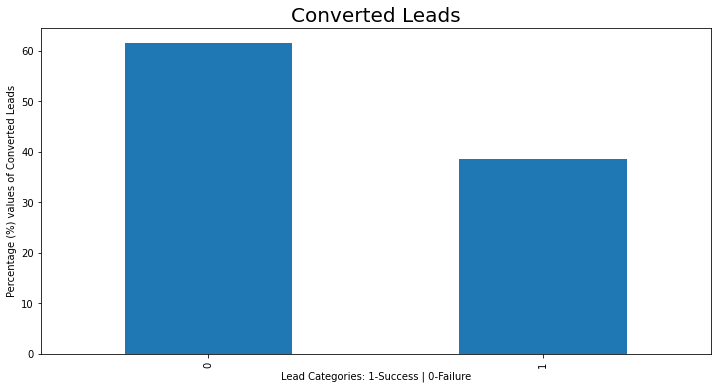

In [11]:
plt.figure(figsize=[12,6])
plt.title("Converted Leads", fontsize=20)
plt.xlabel('Lead Categories: 1-Success | 0-Failure')
plt.ylabel('Percentage (%) values of Converted Leads')
ax = (lead_score_df['Converted'].value_counts(normalize=True)*100).plot.bar()
plt.show()

#### Our dataset constitutes of 38% successfully converted leads data, rest i.e. 62% are not converted data.

### Step 5: Data Wrangling

#### Finding out columns that have 'Select' level

In [12]:
# Using 'isin' method, to filter out columns having 'Select' levels 

cols=list(lead_score_df.columns)
search_cols=['Select']
select_cols=[]
for i in range(len(cols)):
    if len(lead_score_df[cols[i]].isin(search_cols).unique())>1:
        select_cols.append(cols[i])
select_cols


['Specialization',
 'How did you hear about X Education',
 'Lead Profile',
 'City']

In [13]:
# Replacing 'Select' with NaN Which means no option is selected

lead_score_df = lead_score_df.replace('Select',np.nan)

In [14]:
# Check for missing values

round(lead_score_df.isnull().sum()/len(lead_score_df)*100,2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
How did you hear about X Education               78.46
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper 

In [15]:
# Dropping Columns having more than 40% of missing values

drop_cols=lead_score_df.isnull().sum()
drop_cols=drop_cols[drop_cols.values/len(lead_score_df)>=0.40]
drop_cols

How did you hear about X Education    7250
Lead Quality                          4767
Lead Profile                          6855
Asymmetrique Activity Index           4218
Asymmetrique Profile Index            4218
Asymmetrique Activity Score           4218
Asymmetrique Profile Score            4218
dtype: int64

In [16]:
len(drop_cols)

7

In [17]:
# Found out that 7 columns have more than 40% missing values,
# hence dropping these 7 columns and checking the remaining columns for missing values

drop_columns=list(drop_cols.keys())
lead_score_df=lead_score_df.drop(drop_columns,1)  
round(lead_score_df.isnull().sum()/len(lead_score_df)*100,2)

Prospect ID                                       0.00
Lead Number                                       0.00
Lead Origin                                       0.00
Lead Source                                       0.39
Do Not Email                                      0.00
Do Not Call                                       0.00
Converted                                         0.00
TotalVisits                                       1.48
Total Time Spent on Website                       0.00
Page Views Per Visit                              1.48
Last Activity                                     1.11
Country                                          26.63
Specialization                                   36.58
What is your current occupation                  29.11
What matters most to you in choosing a course    29.32
Search                                            0.00
Magazine                                          0.00
Newspaper Article                                 0.00
X Educatio

In [18]:
lead_score_df.head()

Prospect ID  Lead Number              Lead Origin  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737                      API   
1  2a272436-5132-4136-86fa-dcc88c88f482       660728                      API   
2  8cc8c611-a219-4f35-ad23-fdfd2656bd8a       660727  Landing Page Submission   
3  0cc2df48-7cf4-4e39-9de9-19797f9b38cc       660719  Landing Page Submission   
4  3256f628-e534-4826-9d63-4a8b88782852       660681  Landing Page Submission   

      Lead Source Do Not Email Do Not Call  Converted  TotalVisits  \
0      Olark Chat           No          No          0          0.0   
1  Organic Search           No          No          0          5.0   
2  Direct Traffic           No          No          1          2.0   
3  Direct Traffic           No          No          0          1.0   
4          Google           No          No          1          2.0   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                   0.0  Page Visited on Website   
1                          674                   2.5             Email Opened   
2                         1532                   2.0             Email Opened   
3                          305                   1.0              Unreachable   
4                         1428                   1.0        Converted to Lead   

  Country           Specialization What is your current occupation  \
0     NaN                      NaN                      Unemployed   
1   India                      NaN                      Unemployed   
2   India  Business Administration                         Student   
3   India    Media and Advertising                      Unemployed   
4   India                      NaN                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   
1                       Better Career Prospects     No       No   
2                       Better Career Prospects     No       No   
3                       Better Career Prospects     No       No   
4                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   
1                No                 No        No                    No   
2                No                 No        No                    No   
3                No                 No        No                    No   
4                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   
1                      No                                     No   
2                      No                                     No   
3                      No                                     No   
4                      No                                     No   

                                  Tags Update me on Supply Chain Content  \
0          Interested in other courses                                No   
1                              Ringing                                No   
2  Will revert after reading the email                                No   
3                              Ringing                                No   
4  Will revert after reading the email                                No   

  Get updates on DM Content    City I agree to pay the amount through cheque  \
0                        No     NaN                                       No   
1                        No     NaN                                       No   
2                        No  Mumbai                                       No   
3                        No  Mumbai                                       No   
4                        No  Mumbai                                       No   

  A free copy of 

In [19]:
lead_score_df.columns

Index(['Prospect ID', 'Lead Number', 'Lead Origin', 'Lead Source',
       'Do Not Email', 'Do Not Call', 'Converted', 'TotalVisits',
       'Total Time Spent on Website', 'Page Views Per Visit', 'Last Activity',
       'Country', 'Specialization', 'What is your current occupation',
       'What matters most to you in choosing a course', 'Search', 'Magazine',
       'Newspaper Article', 'X Education Forums', 'Newspaper',
       'Digital Advertisement', 'Through Recommendations',
       'Receive More Updates About Our Courses', 'Tags',
       'Update me on Supply Chain Content', 'Get updates on DM Content',
       'City', 'I agree to pay the amount through cheque',
       'A free copy of Mastering The Interview', 'Last Notable Activity'],
      dtype='object')

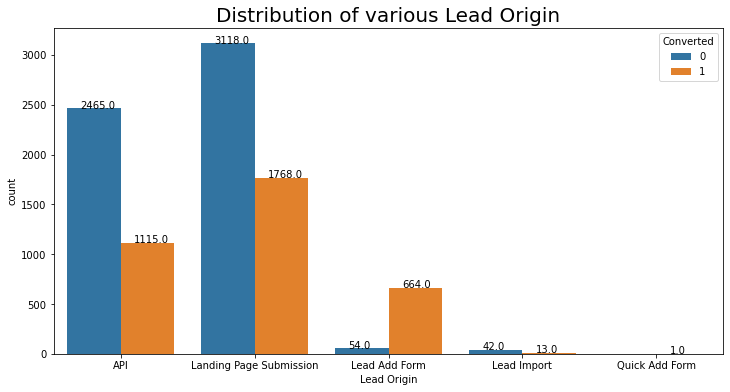

In [20]:
plt.figure(figsize=[12,6])
plt.title("Distribution of various Lead Origin", fontsize=20)
ax = sns.countplot(x='Lead Origin', data=lead_score_df, hue='Converted')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the above chart it is observed that Landing page Submission is the highest lead generator and is also having a highset conversion success.

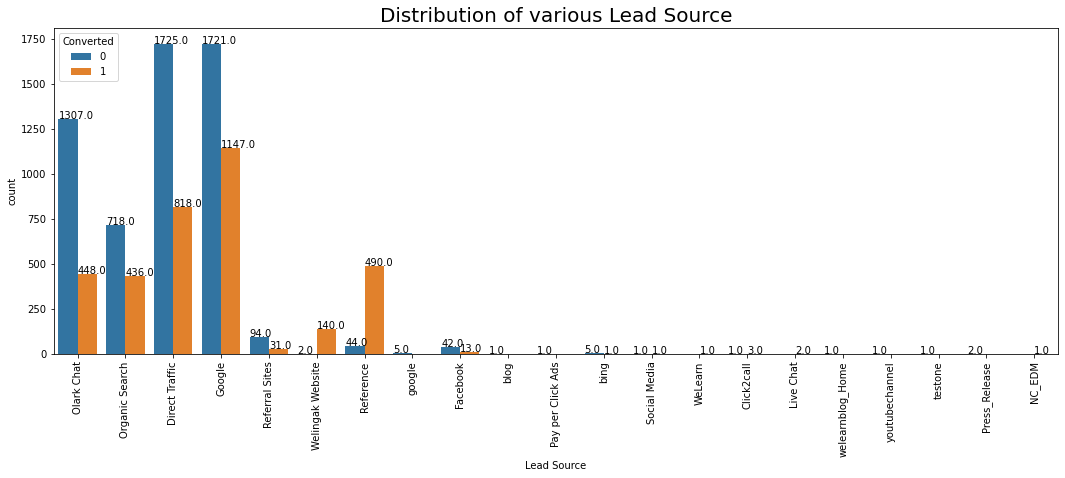

In [21]:
plt.figure(figsize=[18,6])
plt.title("Distribution of various Lead Source", fontsize=20)
ax = sns.countplot(x='Lead Source', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))
plt.show()

#### In the above chart it is visible that in the data Google and google are both there, converting them to single entry.

In [22]:
lead_score_df['Lead Source'] = lead_score_df['Lead Source'].replace(['google'], 'Google')

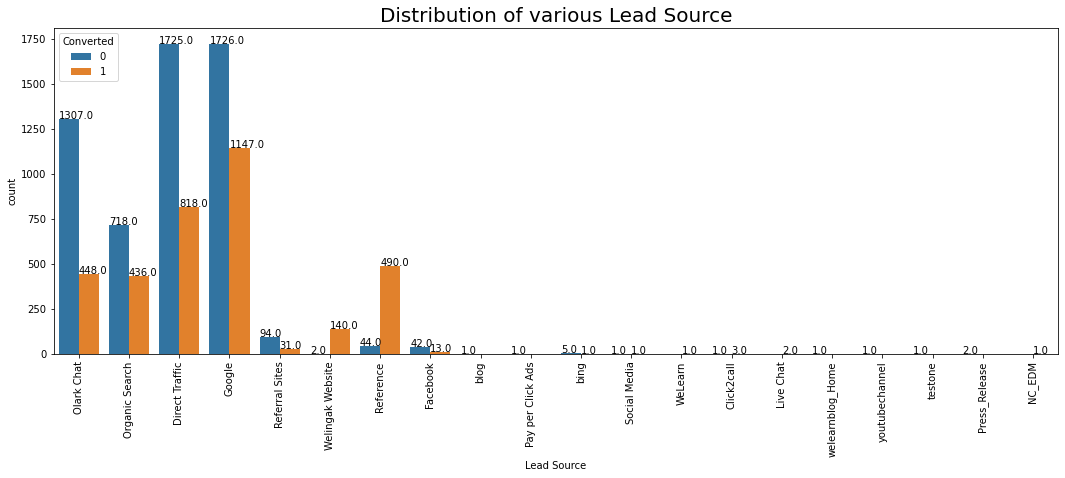

In [23]:
plt.figure(figsize=[18,6])
plt.title("Distribution of various Lead Source", fontsize=20)
ax = sns.countplot(x='Lead Source', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x(), p.get_height()+0.01))
plt.show()

#### From the above chart we can see that Direct Traffic and Google are the highest source of leads with Google having the highest conversion factor.

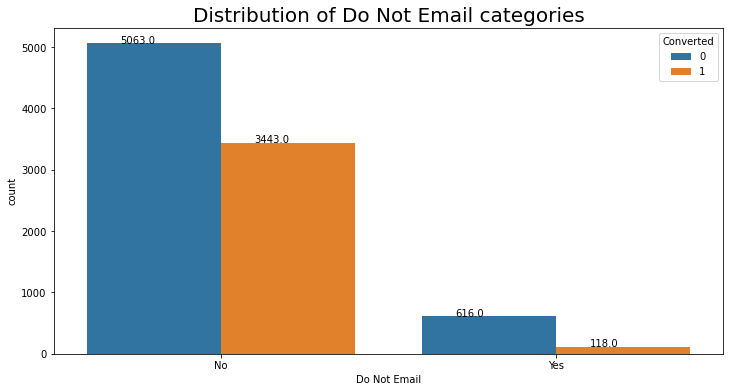

In [24]:
plt.figure(figsize=[12,6])
plt.title("Distribution of Do Not Email categories", fontsize=20)
ax = sns.countplot(x='Do Not Email', data=lead_score_df, hue='Converted')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the above chart we can see that people who have opted to be contacted via email are the highest source of leads and having the highest conversion factor.

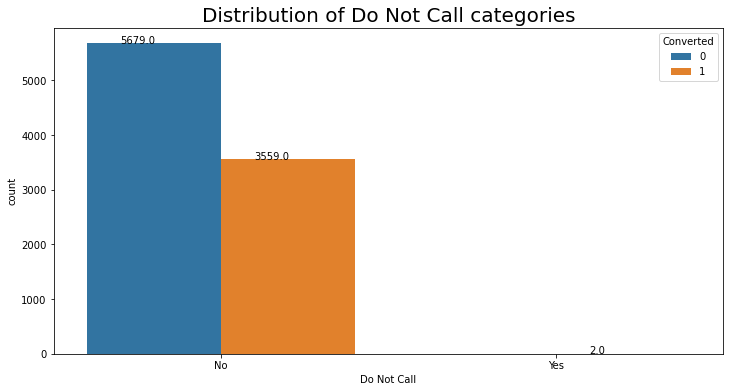

In [25]:
plt.figure(figsize=[12,6])
plt.title("Distribution of Do Not Call categories", fontsize=20)
ax = sns.countplot(x='Do Not Call', data=lead_score_df, hue='Converted')
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the above chart we can see that people who have opted to be called are the highest source of leads and having the highest conversion factor.

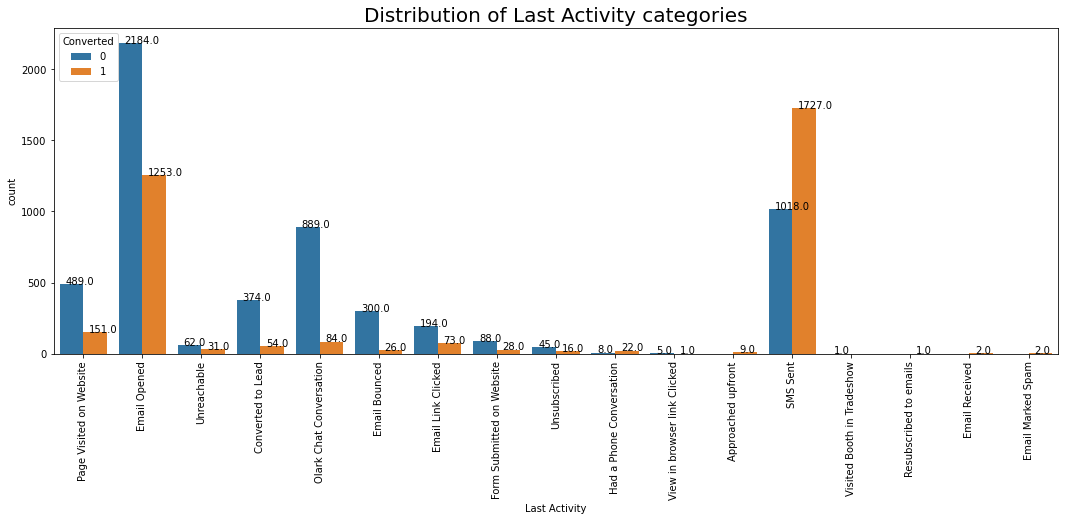

In [26]:
plt.figure(figsize=[18,6])
plt.title("Distribution of Last Activity categories", fontsize=20)
ax = sns.countplot(x='Last Activity', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### This column looks like updated by sales team post-facto, so will drop thtis column for prediction of potential leads

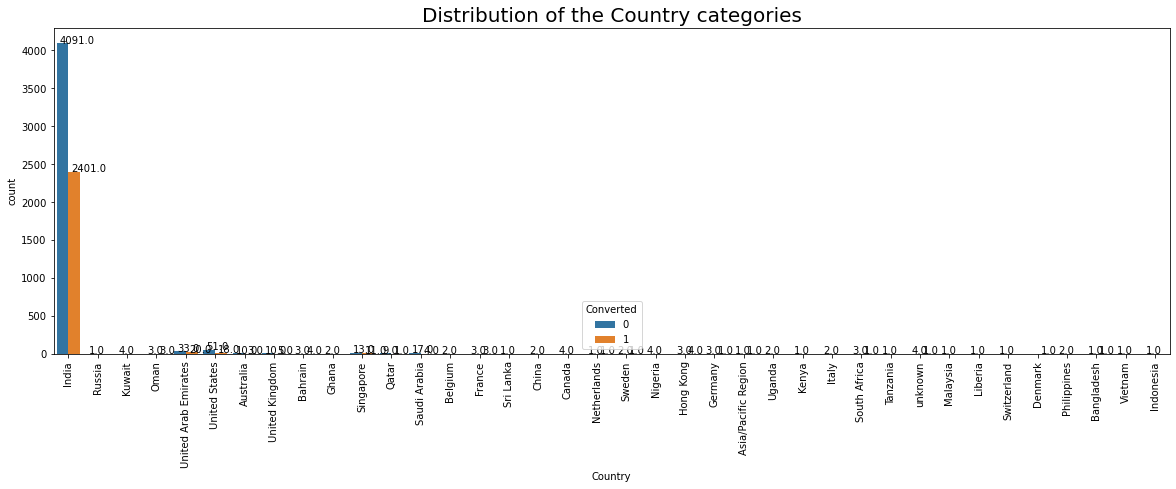

In [27]:
plt.figure(figsize=[20,6])
plt.title("Distribution of the Country categories", fontsize=20)
ax = sns.countplot(x='Country', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### India is the only country with substatial lead generation and successful conversion. Other countries are negligible in the dataset as per the chart.

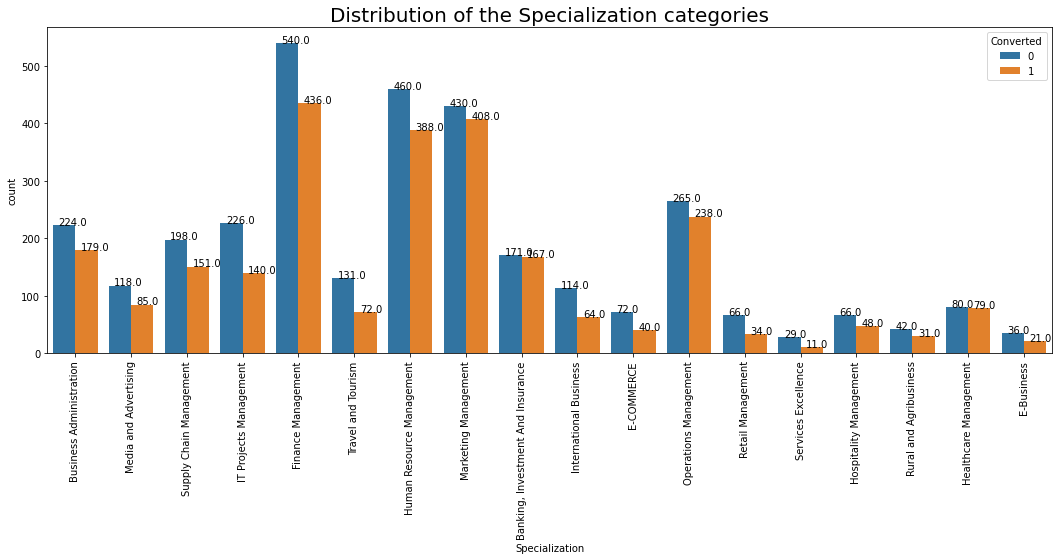

In [28]:
plt.figure(figsize=[18,6])
plt.title("Distribution of the Specialization categories", fontsize=20)
ax = sns.countplot(x='Specialization', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### Finance Management profile has the leading lead generation and successful lead conversion factor.

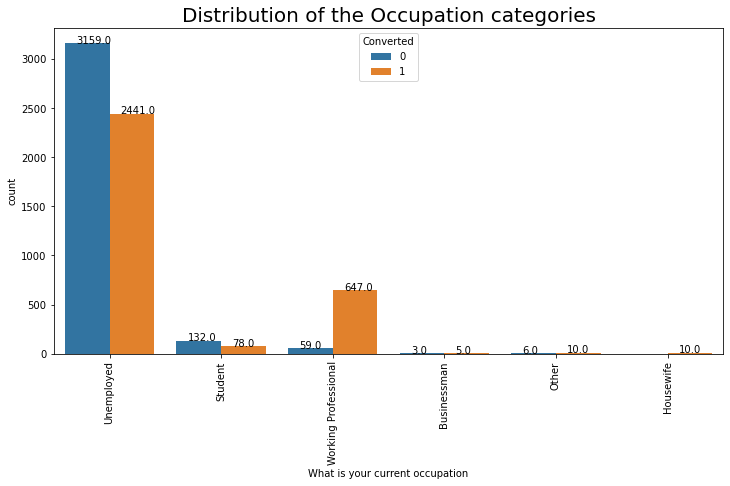

In [29]:
plt.figure(figsize=[12,6])
plt.title("Distribution of the Occupation categories", fontsize=20)
ax = sns.countplot(x='What is your current occupation', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### People who are Unemployed are the leading lead generation and are having the successful lead conversion factor.

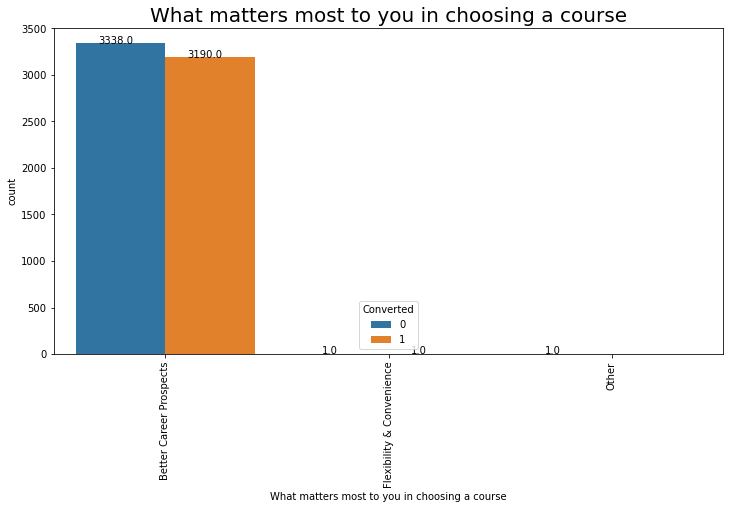

In [30]:
plt.figure(figsize=[12,6])
plt.title("What matters most to you in choosing a course", fontsize=20)
ax = sns.countplot(x='What matters most to you in choosing a course', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### Better career prospect seems to be the only choice choosen by leads.

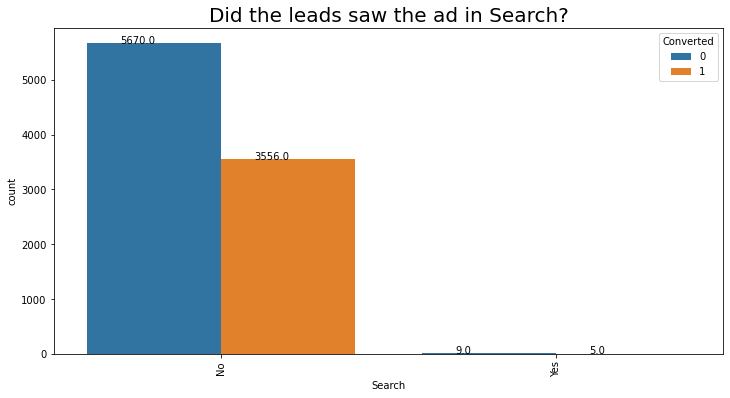

In [31]:
plt.figure(figsize=[12,6])
plt.title("Did the leads saw the ad in Search?", fontsize=20)
ax = sns.countplot(x='Search', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the chart above it seems that the majority of the leads including the successfully converted, never saw the ad of X Education in search medium.

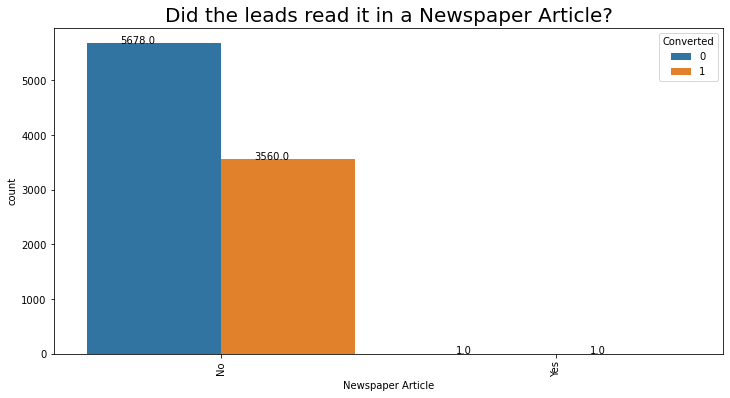

In [32]:
plt.figure(figsize=[12,6])
plt.title("Did the leads read it in a Newspaper Article?", fontsize=20)
ax = sns.countplot(x='Newspaper Article', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the chart above it seems that the majority of the leads including the successfully converted, never read about X Education in any newspaper article.

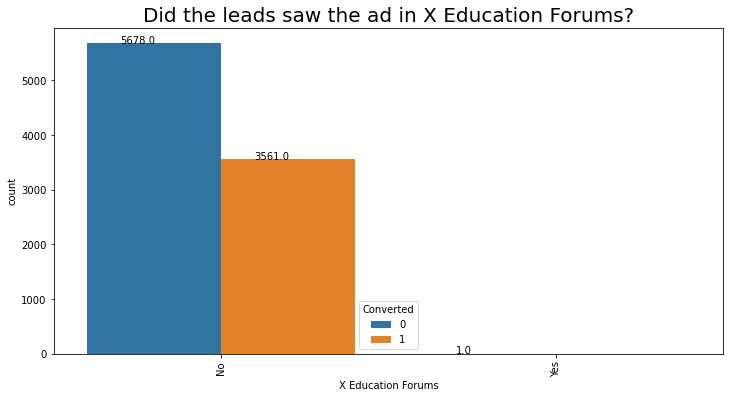

In [33]:
plt.figure(figsize=[12,6])
plt.title("Did the leads saw the ad in X Education Forums?", fontsize=20)
ax = sns.countplot(x='X Education Forums', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the chart above it seems that the majority of the leads including the successfully converted, never saw the ad in X Education Forums.

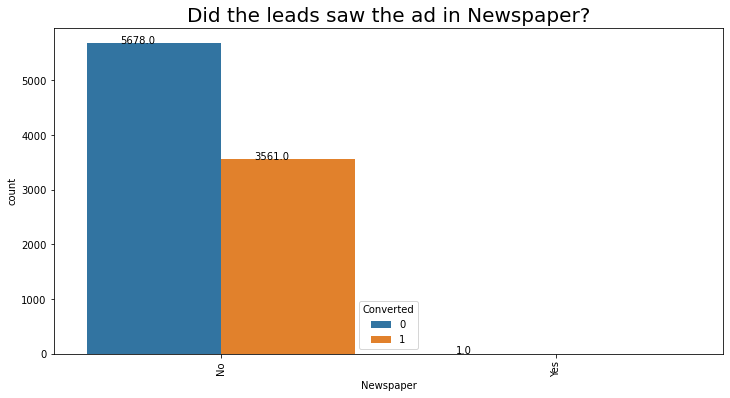

In [34]:
plt.figure(figsize=[12,6])
plt.title("Did the leads saw the ad in Newspaper?", fontsize=20)
ax = sns.countplot(x='Newspaper', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the chart above it seems that the majority of the leads including the successfully converted, never saw the ad of X Education in Newspaper.

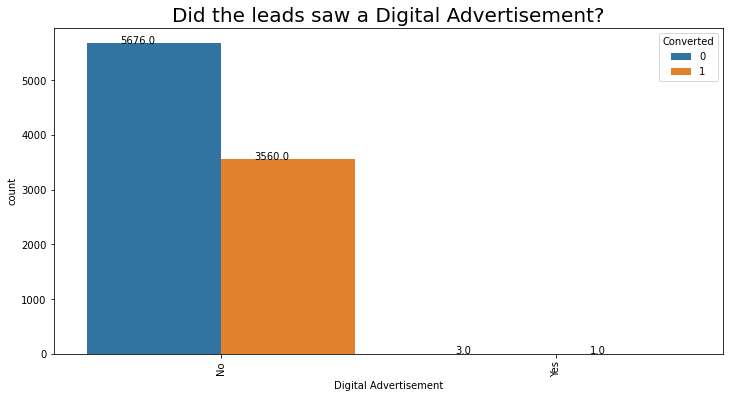

In [35]:
plt.figure(figsize=[12,6])
plt.title("Did the leads saw a Digital Advertisement?", fontsize=20)
ax = sns.countplot(x='Digital Advertisement', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### From the chart above it seems that the majority of the leads including the successfully converted, never saw the ad of X Education through any Digital Advertisement.

#### Most of the successfully converted leads has never seen an ad of X-Education in any medium as is seen from all of the charts above

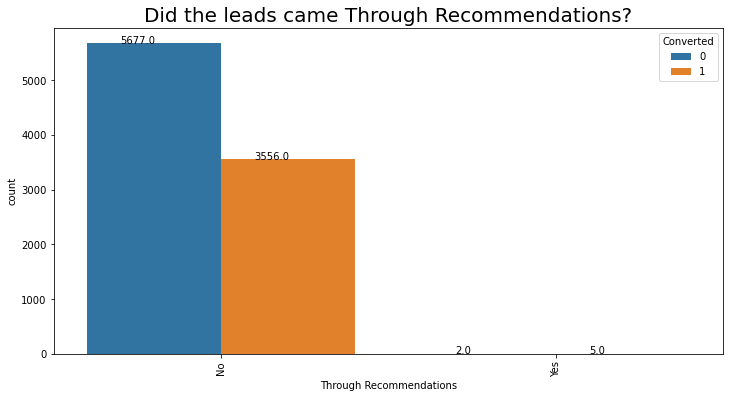

In [36]:
plt.figure(figsize=[12,6])
plt.title("Did the leads came Through Recommendations?", fontsize=20)
ax = sns.countplot(x='Through Recommendations', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### Most of the successfully converted leads are not comming through recommendation as is seen from the chart above

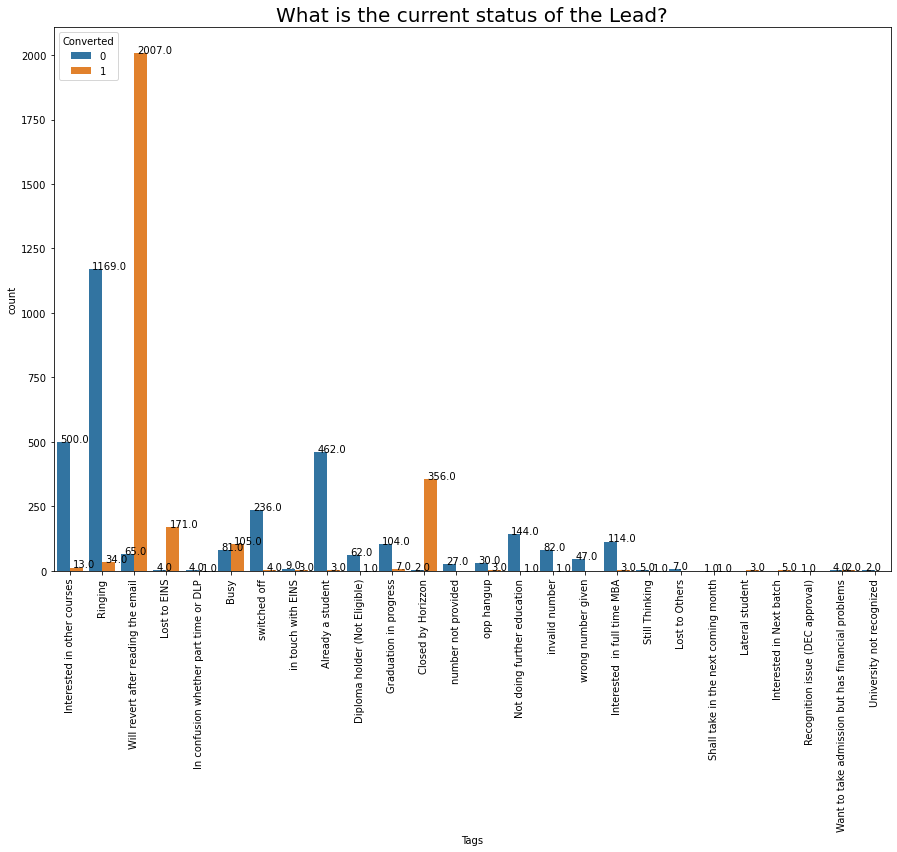

In [37]:
plt.figure(figsize=[15,10])
plt.title("What is the current status of the Lead?", fontsize=20)
ax = sns.countplot(x='Tags', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### This chart highlights that most of the leads who have commited to revert back after reading email has successfully converted. Also, this column appears to be updated post-facto, so this column will be dropped for prediction of potential leads

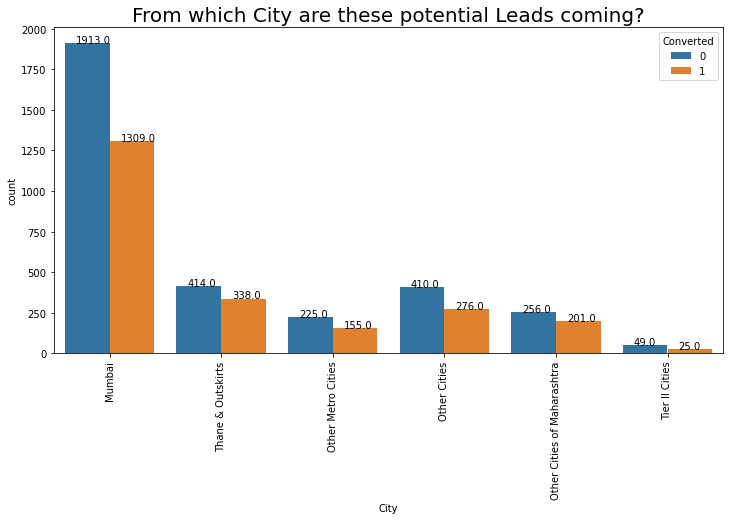

In [38]:
plt.figure(figsize=[12,6])
plt.title("From which City are these potential Leads coming?", fontsize=20)
ax = sns.countplot(x='City', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### Mumbai appears to be the highest contributer from which leads are being generated and is also having a high successful conversion rate

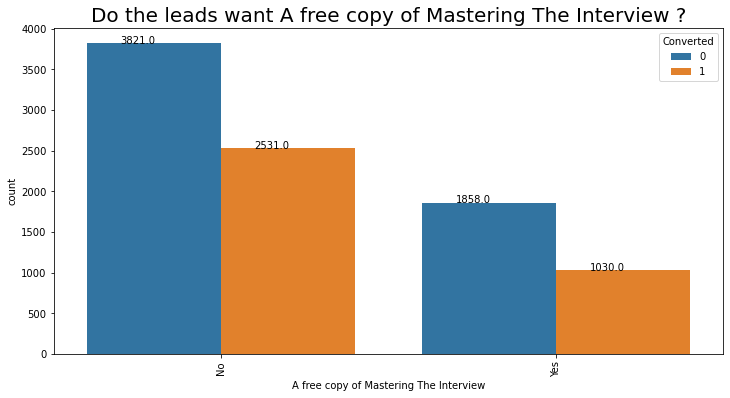

In [39]:
plt.figure(figsize=[12,6])
plt.title("Do the leads want A free copy of Mastering The Interview ?", fontsize=20)
ax = sns.countplot(x='A free copy of Mastering The Interview', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()


#### From the chart we can see that majority of the leads do not want A free copy of Mastering The Interview

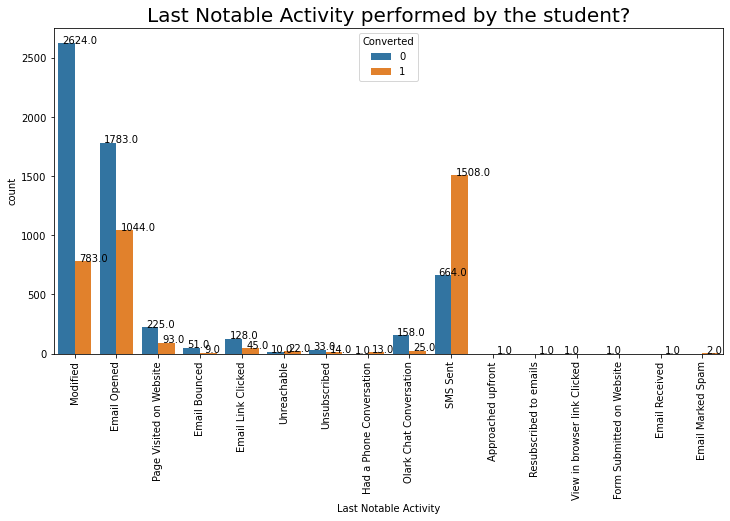

In [40]:
plt.figure(figsize=[12,6])
plt.title("Last Notable Activity performed by the student?", fontsize=20)
ax = sns.countplot(x='Last Notable Activity', data=lead_score_df, hue='Converted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
   ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.10, p.get_height()+0.01))
plt.show()

#### This column appears to be updated post-facto by the sales team, so will be dropped for prediction of potential leads

> Basis our EDA on categorical features we find that
> There are certain columns which are inputted by sales team after interaction with the leads. Hence, needs to be dropped for our model prediction purposes. These columns are:
> - Last Activity
> - Last Notable Activity
> - Tags

> Also basis our EDA on categorical features we find that, no variance observed in these features. Hence, no use in including them in modelling.
> - Do Not Call
> - What matters most to you in choosing a course
> - Search
> - Newspaper Article
> - X Education Forums
> - Newspaper
> - Digital Advertisement
> - Through Recommendations
> - Country
> - Magazine
> - Receive More Updates About Our Courses
> - Update me on Supply Chain Content
> - Get updates on DM Content
> - I agree to pay the amount through cheque

In [41]:
# Based on our EDA on categorical features we are dropping the following columns
drop_features = ['Country','What matters most to you in choosing a course',
                 'Search','Newspaper Article','X Education Forums','Newspaper',
                 'Digital Advertisement','Through Recommendations','Tags','Last Notable Activity','Last Activity',
                 'Magazine','Receive More Updates About Our Courses',
                 'Update me on Supply Chain Content','Get updates on DM Content','I agree to pay the amount through cheque']

lead_score_df.drop(drop_features,axis=1, inplace=True)

In [42]:
#Removing some more unwanted columns as the values in these columns are just indicative of the ID and are not important from an analysis point of view. Hence, can be dropped.

lead_score_df = lead_score_df.drop(['Lead Number','Prospect ID'],1)

#### Checking for outliers & outlier treatment

In [43]:
# let's look at the statistical aspects of the numerical features
lead_score_df.describe(percentiles=[0.05,.25, .5, .75, 0.95])

Converted  TotalVisits  Total Time Spent on Website  \
count  9240.000000  9103.000000                  9240.000000   
mean      0.385390     3.445238                   487.698268   
std       0.486714     4.854853                   548.021466   
min       0.000000     0.000000                     0.000000   
5%        0.000000     0.000000                     0.000000   
25%       0.000000     1.000000                    12.000000   
50%       0.000000     3.000000                   248.000000   
75%       1.000000     5.000000                   936.000000   
95%       1.000000    10.000000                  1562.000000   
max       1.000000   251.000000                  2272.000000   

       Page Views Per Visit  
count           9103.000000  
mean               2.362820  
std                2.161418  
min                0.000000  
5%                 0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
95%                6.000000  
max               55.000000

From the above, we can see that there are outliers present in the numerical variables.

**1**. For **'TotalVisits'**, the 95% quantile is 10 whereas the maximum value is 251. Hence, we will cap these outliers at 95% value.  
**2**. There are no significant outliers in 'Total Time Spent on Website'.  
**3**. For **'Page Views Per Visit'**, similar to 'TotalVisits', we will cap outliers at 95% value.  
**4**. We will not cap at 5% as the minimum value because the 5% value are same for all the variables.

#### Boxplot

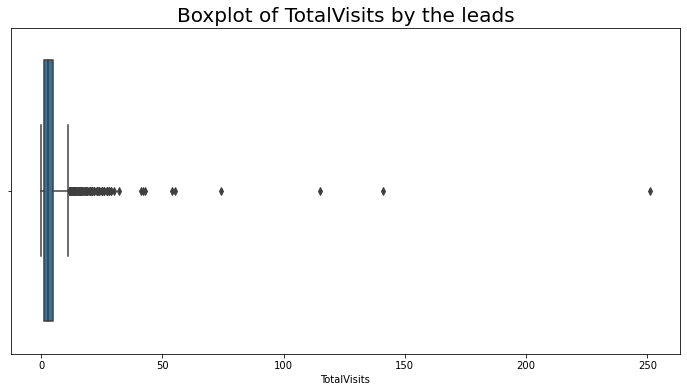

In [44]:
plt.figure(figsize=[12,6])
plt.title("Boxplot of TotalVisits by the leads", fontsize=20)
ax = sns.boxplot(x='TotalVisits', data=lead_score_df)
plt.show()

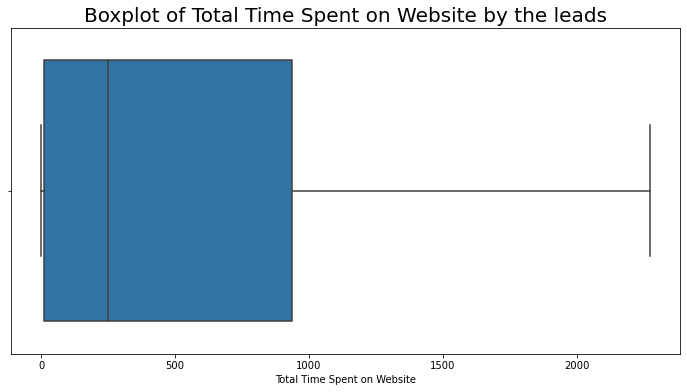

In [45]:
plt.figure(figsize=[12,6])
plt.title("Boxplot of Total Time Spent on Website by the leads", fontsize=20)
ax = sns.boxplot(x='Total Time Spent on Website', data=lead_score_df)
plt.show()

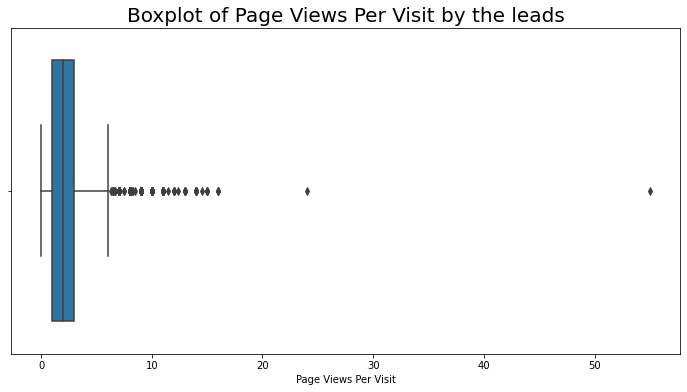

In [46]:
plt.figure(figsize=[12,6])
plt.title("Boxplot of Page Views Per Visit by the leads", fontsize=20)
ax = sns.boxplot(x='Page Views Per Visit', data=lead_score_df)
plt.show()

In [47]:
# Outlier treatment
percentile = lead_score_df['TotalVisits'].quantile([0.95]).values
lead_score_df['TotalVisits'][lead_score_df['TotalVisits'] >= percentile[0]] = percentile[0]

percentile = lead_score_df['Page Views Per Visit'].quantile([0.95]).values
lead_score_df['Page Views Per Visit'][lead_score_df['Page Views Per Visit'] >= percentile[0]] = percentile[0]

In [48]:
# let's look at the statistical aspects of the numerical features after capping
lead_score_df.describe(percentiles=[0.05,.25, .5, .75, 0.95])

Converted  TotalVisits  Total Time Spent on Website  \
count  9240.000000  9103.000000                  9240.000000   
mean      0.385390     3.181918                   487.698268   
std       0.486714     2.781834                   548.021466   
min       0.000000     0.000000                     0.000000   
5%        0.000000     0.000000                     0.000000   
25%       0.000000     1.000000                    12.000000   
50%       0.000000     3.000000                   248.000000   
75%       1.000000     5.000000                   936.000000   
95%       1.000000    10.000000                  1562.000000   
max       1.000000    10.000000                  2272.000000   

       Page Views Per Visit  
count           9103.000000  
mean               2.258944  
std                1.792536  
min                0.000000  
5%                 0.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
95%                6.000000  
max                6.000000

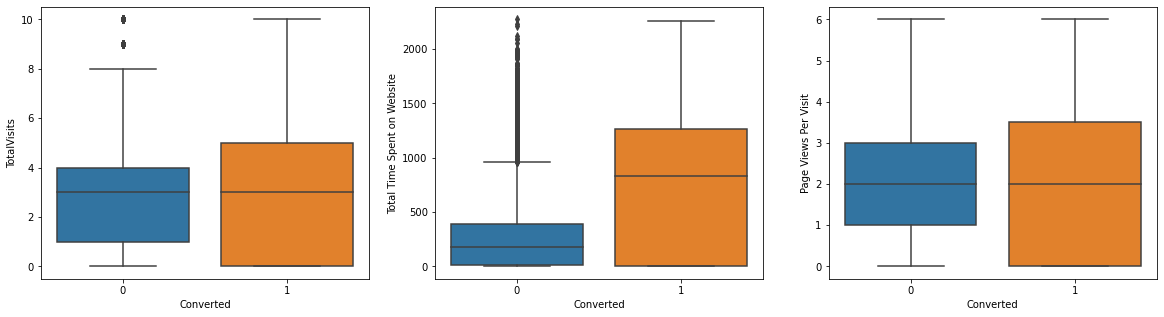

In [49]:
# To plot numerical variables against target variable to analyse relations
num_var = ['TotalVisits','Total Time Spent on Website','Page Views Per Visit']

plt.figure(figsize=(20, 5))
for i in num_var:
    plt.subplot(1,3,num_var.index(i)+1)
    sns.boxplot(y = i , x = 'Converted', data = lead_score_df)
plt.show()

#### 
**1**. 'Total Visits' & 'Page Views Per Visit' variables have the same median for leads that are converted and not converted.  
**2**. 'Total Time Spent on Website' variable has more converted leads 


In [50]:
numeric_features = ['Converted','TotalVisits','Total Time Spent on Website','Page Views Per Visit']

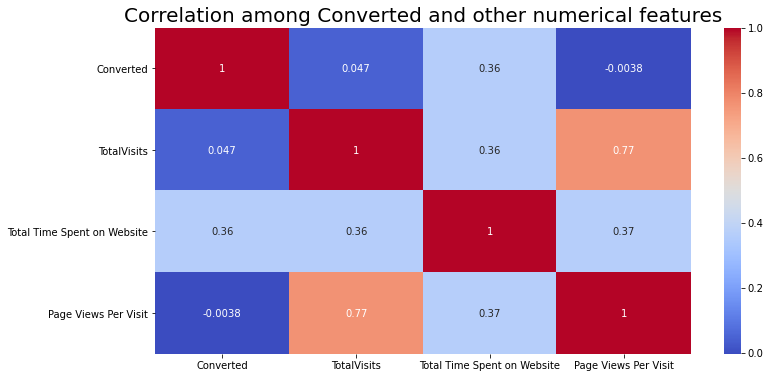

In [51]:
plt.figure(figsize=[12,6])
plt.title("Correlation among Converted and other numerical features", fontsize=20)
sns.heatmap(lead_score_df[numeric_features].corr(), cmap="coolwarm", annot=True)
plt.show()

#### From the above heatmap, it seems there is a very high correlation between TotalVisits and Page Views Per Visit

### Missing Value Imputation

In [52]:
round(lead_score_df.isnull().sum()/lead_score_df.shape[0]*100,2)

Lead Origin                                0.00
Lead Source                                0.39
Do Not Email                               0.00
Do Not Call                                0.00
Converted                                  0.00
TotalVisits                                1.48
Total Time Spent on Website                0.00
Page Views Per Visit                       1.48
Specialization                            36.58
What is your current occupation           29.11
City                                      39.71
A free copy of Mastering The Interview     0.00
dtype: float64

#### Imputing missing values for the column Lead Source

In [53]:
# checking what is the top lead origin against where the values of lead sources are NaN

lead_score_df.loc[lead_score_df['Lead Source'].isnull(),['Lead Origin']].describe(include=np.object)

Lead Origin
count              36
unique              4
top     Lead Add Form
freq               33

In [54]:
# checking what is the top lead source against where Lead Origin == Lead Add Form

lead_score_df.loc[lead_score_df['Lead Origin'] == 'Lead Add Form', ['Lead Source']].describe(include=np.object)

Lead Source
count          685
unique           6
top      Reference
freq           534

In [55]:
# Imputing the missing values of Lead Source with Reference

lead_score_df['Lead Source'].fillna('Reference', inplace=True)

In [56]:
# Cross-checking for successful implementation

lead_score_df['Lead Source'].value_counts(dropna=False)

Google               2873
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             570
Welingak Website      142
Referral Sites        125
Facebook               55
bing                    6
Click2call              4
Press_Release           2
Live Chat               2
Social Media            2
WeLearn                 1
testone                 1
Pay per Click Ads       1
youtubechannel          1
NC_EDM                  1
welearnblog_Home        1
blog                    1
Name: Lead Source, dtype: int64

#### Imputing missing values for the column 'What is your current occupation?'

In [57]:
# Checking what are the top values where occupation in NaN

lead_score_df.loc[lead_score_df['What is your current occupation'].isnull()].describe(include=np.object)

Lead Origin Lead Source Do Not Email Do Not Call      Specialization  \
count         2690        2690         2690        2690                1257   
unique           3          12            2           1                  18   
top            API  Olark Chat           No          No  Finance Management   
freq          1439         862         2420        2690                 214   

       What is your current occupation    City  \
count                                0    1270   
unique                               0       6   
top                                NaN  Mumbai   
freq                               NaN     733   

       A free copy of Mastering The Interview  
count                                    2690  
unique                                      2  
top                                        No  
freq                                     1973

In [58]:
# Checking what are the top values especially of Occupation for Mumbai City

lead_score_df.loc[lead_score_df['City']== 'Mumbai'].describe(include=np.object)

Lead Origin     Lead Source Do Not Email Do Not Call  \
count                      3222            3222         3222        3222   
unique                        4              12            2           2   
top     Landing Page Submission  Direct Traffic           No          No   
freq                       2793            1326         2931        3220   

            Specialization What is your current occupation    City  \
count                 3121                            2489    3222   
unique                  18                               6       1   
top     Finance Management                      Unemployed  Mumbai   
freq                   610                            2131    3222   

       A free copy of Mastering The Interview  
count                                    3222  
unique                                      2  
top                                        No  
freq                                     1612

In [59]:
#Based on the above analysis filling the missing occupations with Unemployed

lead_score_df['What is your current occupation'].fillna('Unemployed', inplace=True)

In [60]:
# Cross-checking for successful implementation

lead_score_df['What is your current occupation'].value_counts(dropna=False)

Unemployed              8290
Working Professional     706
Student                  210
Other                     16
Housewife                 10
Businessman                8
Name: What is your current occupation, dtype: int64

#### Imputing missing values for the column City

In [61]:
# Imputing the missing values below of the city with it's mode, as based on our earlier EDA.

lead_score_df['City'].fillna(lead_score_df['City'].mode()[0], inplace=True)

In [62]:
# Cross-checking for successful implementation

lead_score_df['City'].value_counts(dropna=False)

Mumbai                         6891
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: City, dtype: int64

#### Imputing missing values for the column Specialization

In [63]:
# There are lot of different specializations as seen in the EDA, it is possible that the specialization is not provided either the customer does not have specialization or thte customer's specialization is not available in the option provided.Replace all the NaN values with 'Missing' for the 'Specialization' Categorical variables

lead_score_df['Specialization'] = lead_score_df['Specialization'].replace(np.nan, 'Missing')


In [64]:
# Cross-checking for successful implementation

lead_score_df['Specialization'].value_counts(dropna=False)

Missing                              3380
Finance Management                    976
Human Resource Management             848
Marketing Management                  838
Operations Management                 503
Business Administration               403
IT Projects Management                366
Supply Chain Management               349
Banking, Investment And Insurance     338
Media and Advertising                 203
Travel and Tourism                    203
International Business                178
Healthcare Management                 159
Hospitality Management                114
E-COMMERCE                            112
Retail Management                     100
Rural and Agribusiness                 73
E-Business                             57
Services Excellence                    40
Name: Specialization, dtype: int64

In [65]:
round(lead_score_df.isnull().sum()/lead_score_df.shape[0]*100,2)

Lead Origin                               0.00
Lead Source                               0.00
Do Not Email                              0.00
Do Not Call                               0.00
Converted                                 0.00
TotalVisits                               1.48
Total Time Spent on Website               0.00
Page Views Per Visit                      1.48
Specialization                            0.00
What is your current occupation           0.00
City                                      0.00
A free copy of Mastering The Interview    0.00
dtype: float64

In [66]:
# Impute the missing values for the numerical columns with Mean, since median and mean after clamping are almost
# same and mean reflects the variance in the data much more clearly than median

lead_score_df['TotalVisits'].fillna((lead_score_df['TotalVisits'].mean()), inplace=True)
lead_score_df['Page Views Per Visit'].fillna((lead_score_df['Page Views Per Visit'].mean()), inplace=True)

In [67]:
round(lead_score_df.isnull().sum()/lead_score_df.shape[0]*100,2)

Lead Origin                               0.0
Lead Source                               0.0
Do Not Email                              0.0
Do Not Call                               0.0
Converted                                 0.0
TotalVisits                               0.0
Total Time Spent on Website               0.0
Page Views Per Visit                      0.0
Specialization                            0.0
What is your current occupation           0.0
City                                      0.0
A free copy of Mastering The Interview    0.0
dtype: float64

#### All missing values have now been successfully imputed.

### Step 6: Variable Transformation for modelling

In [68]:
lead_score_df.columns

Index(['Lead Origin', 'Lead Source', 'Do Not Email', 'Do Not Call',
       'Converted', 'TotalVisits', 'Total Time Spent on Website',
       'Page Views Per Visit', 'Specialization',
       'What is your current occupation', 'City',
       'A free copy of Mastering The Interview'],
      dtype='object')

#### Converting some binary variables (Yes/No) to 0/1


In [69]:
# List of variables to map

binarylist =  ['Do Not Email', 'Do Not Call', 'A free copy of Mastering The Interview']

# Defining the map function
def binary_map(x):
    return x.map({'Yes': 1, "No": 0})

# Applying the function 
lead_score_df[binarylist] = lead_score_df[binarylist].apply(binary_map)

#### Dummy variable creation for the categorical columns

In [70]:
# Creating a dummy variable for some of the categorical variables and dropping the first one.

dummy1 = pd.get_dummies(lead_score_df[['Lead Origin', 'Lead Source', 'Specialization' , 'What is your current occupation', 'City']], drop_first=True)

# Add the results to the master dataframe
lead_score_df = pd.concat([lead_score_df, dummy1], axis=1)
lead_score_df

Lead Origin     Lead Source  Do Not Email  Do Not Call  \
0                         API      Olark Chat             0            0   
1                         API  Organic Search             0            0   
2     Landing Page Submission  Direct Traffic             0            0   
3     Landing Page Submission  Direct Traffic             0            0   
4     Landing Page Submission          Google             0            0   
...                       ...             ...           ...          ...   
9235  Landing Page Submission  Direct Traffic             1            0   
9236  Landing Page Submission  Direct Traffic             0            0   
9237  Landing Page Submission  Direct Traffic             1            0   
9238  Landing Page Submission          Google             0            0   
9239  Landing Page Submission  Direct Traffic             0            0   

      Converted  TotalVisits  Total Time Spent on Website  \
0             0          0.0                            0   
1             0          5.0                          674   
2             1          2.0                         1532   
3             0          1.0                          305   
4             1          2.0                         1428   
...         ...          ...                          ...   
9235          1          8.0                         1845   
9236          0          2.0                          238   
9237          0          2.0                          199   
9238          1          3.0                          499   
9239          1          6.0                         1279   

      Page Views Per Visit             Specialization  \
0                     0.00                    Missing   
1                     2.50                    Missing   
2                     2.00    Business Administration   
3                     1.00      Media and Advertising   
4                     1.00                    Missing   
...                    ...                        ...   
9235                  2.67     IT Projects Management   
9236                  2.00      Media and Advertising   
9237                  2.00    Business Administration   
9238                  3.00  Human Resource Management   
9239                  3.00    Supply Chain Management   

     What is your current occupation                City  \
0                         Unemployed              Mumbai   
1                         Unemployed              Mumbai   
2                            Student              Mumbai   
3                         Unemployed              Mumbai   
4                         Unemployed              Mumbai   
...                              ...                 ...   
9235                      Unemployed              Mumbai   
9236                      Unemployed              Mumbai   
9237                      Unemployed              Mumbai   
9238                      Unemployed  Other Metro Cities   
9239                      Unemployed        Other Cities   

      A free copy of Mastering The Interview  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   
...                                      ...   
9235                                       0   
9236                                       1   
9237                                       1   
9238                                       0   
9239                                       1   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                       0                          0   
1                                       0                          0   
2                                       1                          0   
3                                       1                          0   
4                            

In [71]:
lead_score_df.shape

(9240, 63)

#### Dropping the repeated variables

In [72]:
# We have created dummies for the below variables, so we can drop them

lead_score_df = lead_score_df.drop(['Lead Origin', 'Lead Source', 'Specialization' , 'What is your current occupation', 'City'], 1)

In [73]:
# Drop the sepcific dummy column Specialization_Missing as it makes no business sense.

lead_score_df.drop('Specialization_Missing', axis=1, inplace=True )

In [74]:
lead_score_df

Do Not Email  Do Not Call  Converted  TotalVisits  \
0                0            0          0          0.0   
1                0            0          0          5.0   
2                0            0          1          2.0   
3                0            0          0          1.0   
4                0            0          1          2.0   
...            ...          ...        ...          ...   
9235             1            0          1          8.0   
9236             0            0          0          2.0   
9237             1            0          0          2.0   
9238             0            0          1          3.0   
9239             0            0          1          6.0   

      Total Time Spent on Website  Page Views Per Visit  \
0                               0                  0.00   
1                             674                  2.50   
2                            1532                  2.00   
3                             305                  1.00   
4                            1428                  1.00   
...                           ...                   ...   
9235                         1845                  2.67   
9236                          238                  2.00   
9237                          199                  2.00   
9238                          499                  3.00   
9239                         1279                  3.00   

      A free copy of Mastering The Interview  \
0                                          0   
1                                          0   
2                                          1   
3                                          0   
4                                          0   
...                                      ...   
9235                                       0   
9236                                       1   
9237                                       1   
9238                                       0   
9239                                       1   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                       0                          0   
1                                       0                          0   
2                                       1                          0   
3                                       1                          0   
4                                       1                          0   
...                                   ...                        ...   
9235                                    1                          0   
9236                                    1                          0   
9237                                    1                          0   
9238                                    1                          0   
9239                                    1                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   
...                       ...                         ...   
9235                        0                           0   
9236                        0                           0   
9237                        0                           0   
9238                        0                           0   
9239                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                              0                     0                   0   
1                              0                     0                   0   
2                              1                     0                   0   
3                              1                     0                   0   
4                      

In [75]:
round(lead_score_df.isnull().sum()/lead_score_df.shape[0]*100,2)

Do Not Email                                            0.0
Do Not Call                                             0.0
Converted                                               0.0
TotalVisits                                             0.0
Total Time Spent on Website                             0.0
Page Views Per Visit                                    0.0
A free copy of Mastering The Interview                  0.0
Lead Origin_Landing Page Submission                     0.0
Lead Origin_Lead Add Form                               0.0
Lead Origin_Lead Import                                 0.0
Lead Origin_Quick Add Form                              0.0
Lead Source_Direct Traffic                              0.0
Lead Source_Facebook                                    0.0
Lead Source_Google                                      0.0
Lead Source_Live Chat                                   0.0
Lead Source_NC_EDM                                      0.0
Lead Source_Olark Chat                  

In [76]:
lead_score_df.shape

(9240, 57)

#### Now we don't have any missing values

### Step 7: Test-Train Split

In [77]:
# Putting feature variable to X

X = lead_score_df.drop(['Converted'], axis=1)
X.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
0             0            0          0.0                            0   
1             0            0          5.0                          674   
2             0            0          2.0                         1532   
3             0            0          1.0                          305   
4             0            0          2.0                         1428   

   Page Views Per Visit  A free copy of Mastering The Interview  \
0                   0.0                                       0   
1                   2.5                                       0   
2                   2.0                                       1   
3                   1.0                                       0   
4                   1.0                                       0   

   Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
0                                    0                          0   
1                                    0                          0   
2                                    1                          0   
3                                    1                          0   
4                                    1                          0   

   Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
0                        0                           0   
1                        0                           0   
2                        0                           0   
3                        0                           0   
4                        0                           0   

   Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
0                           0                     0                   0   
1                           0                     0                   0   
2                           1                     0                   0   
3                           1                     0                   0   
4                           0                     0                   1   

   Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
0                      0                   0                       1   
1                      0                   0                       0   
2                      0                   0                       0   
3                      0                   0                       0   
4                      0                   0                       0   

   Lead Source_Organic Search  Lead Source_Pay per Click Ads  \
0                           0                              0   
1                           1                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   

   Lead Source_Press_Release  Lead Source_Reference  \
0                          0                      0   
1                          0                      0   
2                          0                      0   
3                          0                      0   
4                          0                      0   

   Lead Source_Referral Sites  Lead Source_Social Media  Lead Source_WeLearn  \
0                           0                         0                    0   
1                           0                         0                    0   
2                           0                         0                    0   
3                           0                         0                    0   
4                           0                         0                    0   

   Lead Source_Welingak Website  Lead Source_bing  Lead Source_blog  \
0                             0                 0                 0   
1                             0                 0                 0   
2                             0                 0                 0   
3                         

In [78]:
X.shape

(9240, 56)

In [79]:
# Putting response variable to y

y = lead_score_df['Converted']

y.head()

0    0
1    0
2    1
3    0
4    1
Name: Converted, dtype: int64

In [80]:
y.shape

(9240,)

In [81]:
# Splitting the data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=100)

### Step 8: Feature Scaling

In [82]:
X_train.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
1871             0            0          0.0                            0   
6795             0            0          4.0                          487   
3516             0            0          5.0                          106   
8105             0            0          5.0                         1230   
3934             0            0          0.0                            0   

      Page Views Per Visit  A free copy of Mastering The Interview  \
1871                  0.00                                       0   
6795                  1.33                                       1   
3516                  2.50                                       0   
8105                  5.00                                       0   
3934                  0.00                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
1871                           0                     0                   0   
6795                           1                     0                   0   
3516                           0                     0                   0   
8105                           0                     0                   1   
3934                           0                     0                   0   

      Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
1871                      0                   0                       1   
6795                      0                   0                       0   
3516                      0                   0                       1   
8105                      0                   0                       0   
3934                      0                   0                       1   

      Lead Source_Organic Search  Lead Source_Pay per Click Ads  \
1871                           0                              0   
6795                           0                              0   
3516                           0                              0   
8105                           0                              0   
3934                           0                              0   

      Lead Source_Press_Release  Lead Source_Reference  \
1871                          0                      0   
6795                          0                      0   
3516                          0                      0   
8105                          0                      0   
3934                          0                      0   

      Lead Source_Referral Sites  Lead Source_Social Media  \
1871                           0                         0   
6795                           0                         0   
3516                           0                         0   
8105                           0                         0   
3934                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
1871                    0                             0                 0   
6795                    0                             0                 0   
3516                    0                     

In [83]:
scaler = StandardScaler()

X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.fit_transform(X_train[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_train.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
1871             0            0    -1.150743                    -0.885371   
6795             0            0     0.298722                     0.005716   
3516             0            0     0.661088                    -0.691418   
8105             0            0     0.661088                     1.365219   
3934             0            0    -1.150743                    -0.885371   

      Page Views Per Visit  A free copy of Mastering The Interview  \
1871             -1.269100                                       0   
6795             -0.518752                                       1   
3516              0.141328                                       0   
8105              1.551757                                       0   
3934             -1.269100                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
1871                                    0                          0   
6795                                    1                          0   
3516                                    0                          0   
8105                                    1                          0   
3934                                    0                          0   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
1871                        0                           0   
6795                        0                           0   
3516                        0                           0   
8105                        0                           0   
3934                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
1871                           0                     0                   0   
6795                           1                     0                   0   
3516                           0                     0                   0   
8105                           0                     0                   1   
3934                           0                     0                   0   

      Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
1871                      0                   0                       1   
6795                      0                   0                       0   
3516                      0                   0                       1   
8105                      0                   0                       0   
3934                      0                   0                       1   

      Lead Source_Organic Search  Lead Source_Pay per Click Ads  \
1871                           0                              0   
6795                           0                              0   
3516                           0                              0   
8105                           0                              0   
3934                           0                              0   

      Lead Source_Press_Release  Lead Source_Reference  \
1871                          0                      0   
6795                          0                      0   
3516                          0                      0   
8105                          0                      0   
3934                          0                      0   

      Lead Source_Referral Sites  Lead Source_Social Media  \
1871                           0                         0   
6795                           0                         0   
3516                           0                         0   
8105                           0                         0   
3934                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
1871                    0                             0                 0   
6795                    0                             0                 0   
3516                    0                     

In [84]:
### Checking the Conversion Rate

converted = round((sum(lead_score_df['Converted'])/len(lead_score_df['Converted'].index))*100,2)
converted

38.54

#### We have 38.5% conversion rate

#### Looking at Correlations After dummy variable creation

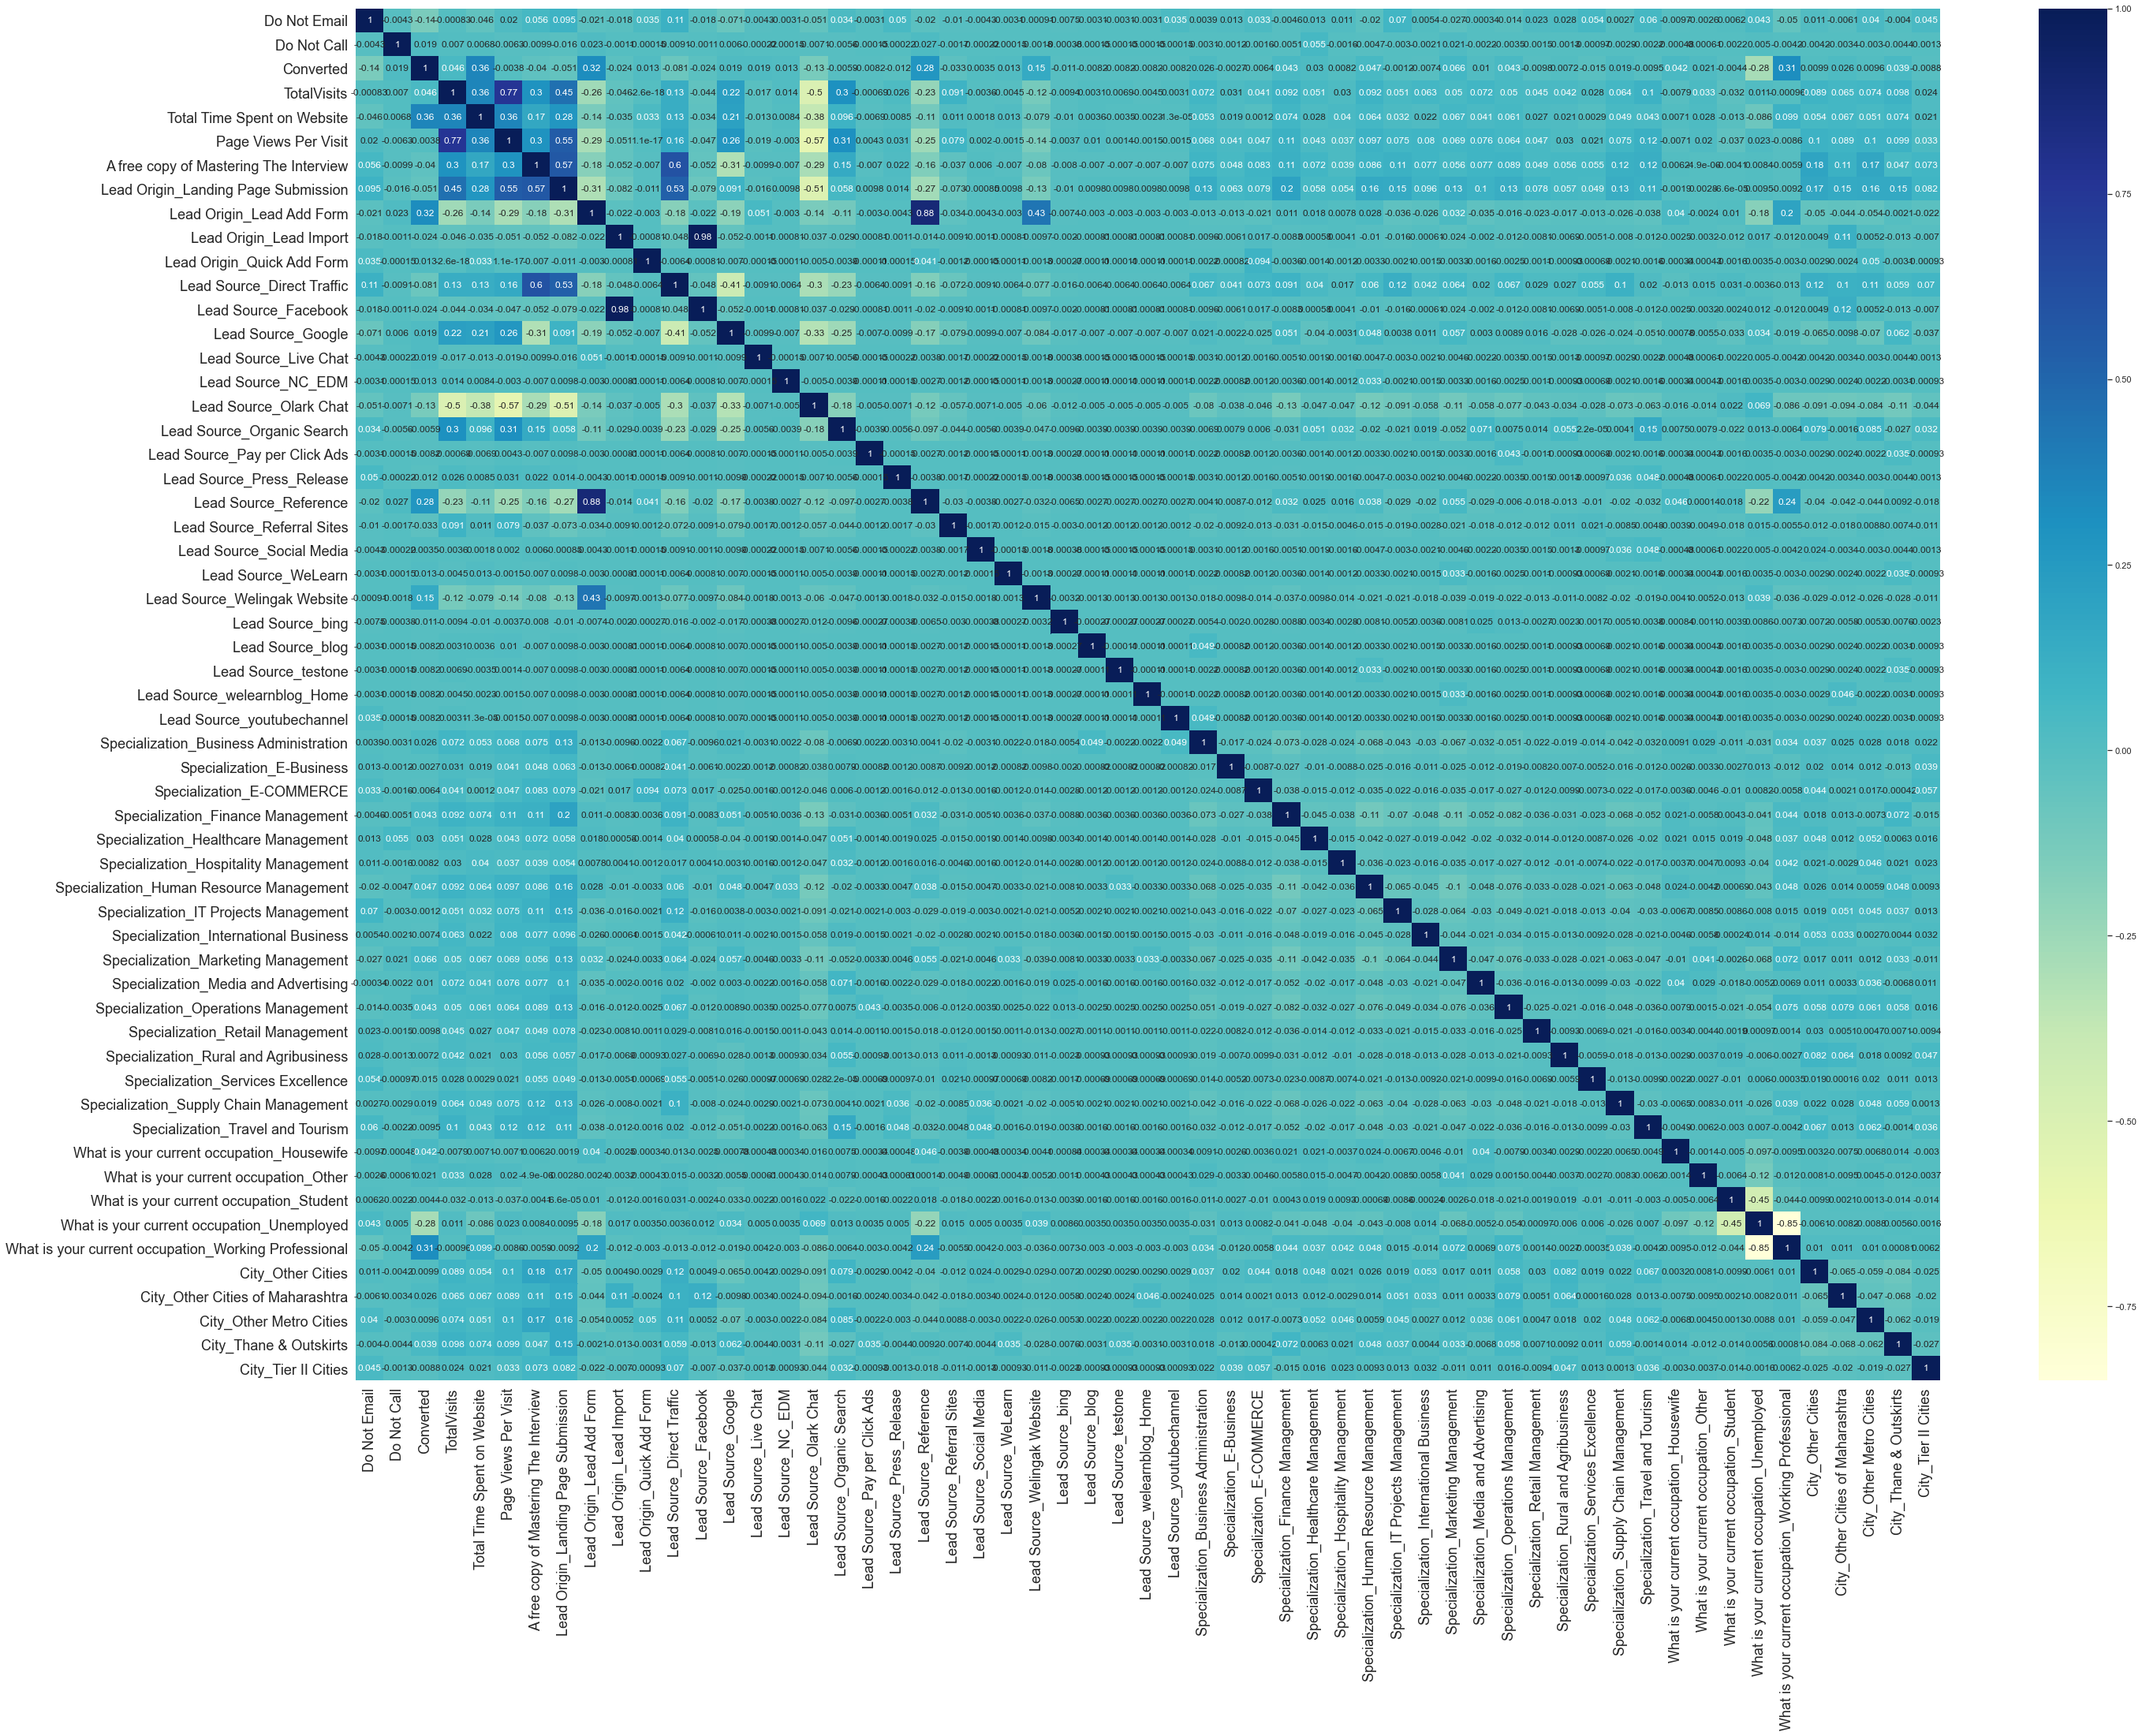

In [85]:
# Let's see the correlation matrix 

plt.figure(figsize = (45,32)) # Size of the figure
sns.set(font_scale=1.0)
res=sns.heatmap(lead_score_df.corr(),annot = True ,cmap="YlGnBu" )
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
plt.show()

In [86]:
high_cor_function(lead_score_df)

max corr: 0.9817093086554165 , min corr:  -0.8496528018461855


Lead Origin_Lead Import  Lead Source_Facebook         0.981709
Lead Source_Reference    Lead Origin_Lead Add Form    0.878316
TotalVisits              Page Views Per Visit         0.767588
dtype: float64

#### Dropping highly correlated dummy variables

In [87]:
X_train = X_train.drop(['Lead Source_Facebook','Lead Source_Reference','Page Views Per Visit'], 1)

#### Checking the Correlation Matrix

#### After dropping highly correlated variables now let's check the correlation matrix again

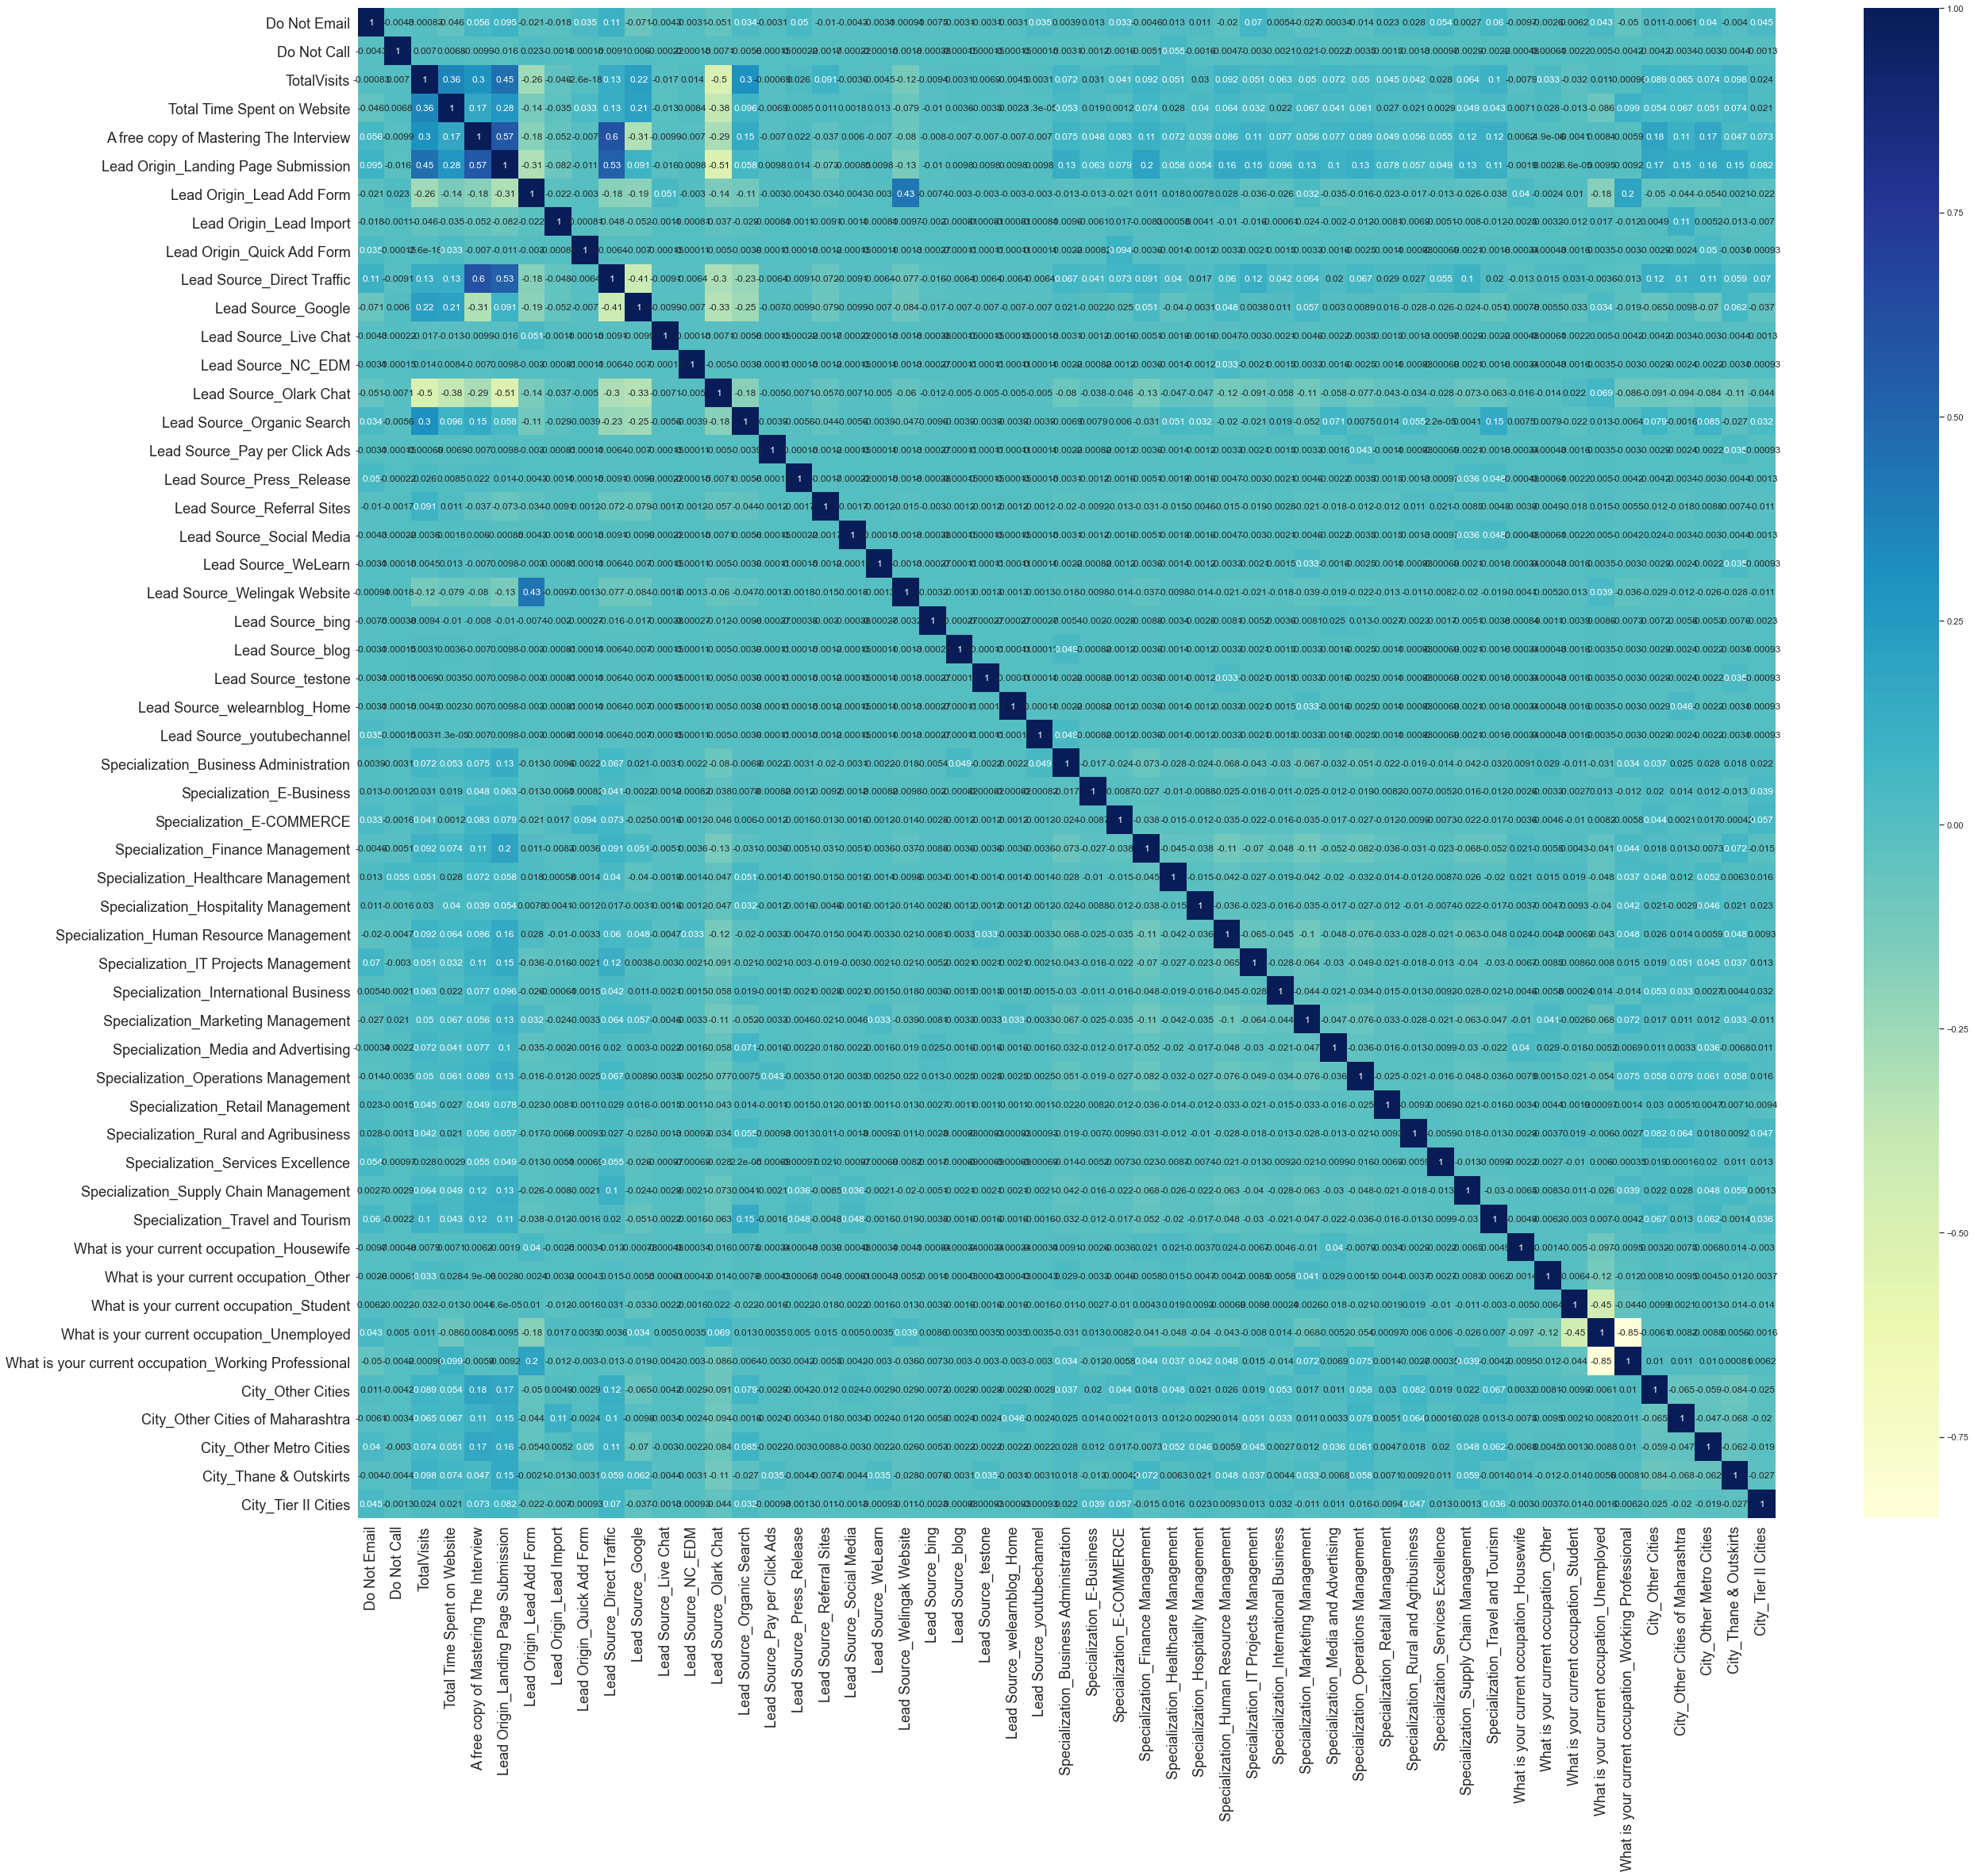

In [88]:
plt.figure(figsize = (40,35))        # Size of the figure
sns.set(font_scale=1.0)
res=sns.heatmap(lead_score_df[X_train.columns].corr(),annot = True ,cmap="YlGnBu" )
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 18)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 18)
plt.show()

### Step 9: Model Building

#### As displayed in the summary above there are many variable with insignificant p values. In the next step will use RFE, we have close to 51 features. It is not recommended to manually eliminate these features. So let's now build a model using recursive feature elimination(RFE) to select features

#### Feature Selection Using RFE

In [89]:
logreg = LogisticRegression()
rfe = RFE(logreg, 20)             # running RFE with 20 variables as output
rfe = rfe.fit(X_train, y_train)

In [90]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('Do Not Email', True, 1),
 ('Do Not Call', False, 23),
 ('TotalVisits', False, 25),
 ('Total Time Spent on Website', True, 1),
 ('A free copy of Mastering The Interview', False, 26),
 ('Lead Origin_Landing Page Submission', False, 12),
 ('Lead Origin_Lead Add Form', True, 1),
 ('Lead Origin_Lead Import', True, 1),
 ('Lead Origin_Quick Add Form', False, 33),
 ('Lead Source_Direct Traffic', True, 1),
 ('Lead Source_Google', True, 1),
 ('Lead Source_Live Chat', False, 16),
 ('Lead Source_NC_EDM', False, 17),
 ('Lead Source_Olark Chat', False, 22),
 ('Lead Source_Organic Search', True, 1),
 ('Lead Source_Pay per Click Ads', False, 24),
 ('Lead Source_Press_Release', True, 1),
 ('Lead Source_Referral Sites', True, 1),
 ('Lead Source_Social Media', False, 32),
 ('Lead Source_WeLearn', False, 21),
 ('Lead Source_Welingak Website', True, 1),
 ('Lead Source_bing', False, 29),
 ('Lead Source_blog', True, 1),
 ('Lead Source_testone', False, 34),
 ('Lead Source_welearnblog_Home', False, 14),
 ('

In [91]:
col = list(X_train.columns[rfe.support_])

In [92]:
len(col)

20

In [93]:
X_train.columns[~rfe.support_]

Index(['Do Not Call', 'TotalVisits', 'A free copy of Mastering The Interview',
       'Lead Origin_Landing Page Submission', 'Lead Origin_Quick Add Form',
       'Lead Source_Live Chat', 'Lead Source_NC_EDM', 'Lead Source_Olark Chat',
       'Lead Source_Pay per Click Ads', 'Lead Source_Social Media',
       'Lead Source_WeLearn', 'Lead Source_bing', 'Lead Source_testone',
       'Lead Source_welearnblog_Home', 'Lead Source_youtubechannel',
       'Specialization_Business Administration', 'Specialization_E-Business',
       'Specialization_Finance Management',
       'Specialization_Hospitality Management',
       'Specialization_Human Resource Management',
       'Specialization_International Business',
       'Specialization_Marketing Management',
       'Specialization_Media and Advertising',
       'Specialization_Operations Management',
       'Specialization_Retail Management',
       'Specialization_Services Excellence',
       'Specialization_Supply Chain Management',
       'S

#### Assessing the model with StatsModels

#### Model 1

In [94]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6447
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3007.1
Date:                Tue, 15 Mar 2022   Deviance:                       6014.2
Time:                        14:07:44   Pearson chi2:                 7.83e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5232      1.015     -0.515      0.606      -2.513       1.467
Do Not Email                                            -1.3676      0.158     -8.659      0.000      -1.677      -1.058
Total Time Spent on Website                              1.1038      0.037     29.610      0.000       1.031       1.177
Lead Origin_Lead Add Form                                3.0171      0.189     15.950      0.000       2.646       3.388
Lead Origin_Lead Import                                 -1.0232      0.529     -1.936      0.053      -2.059       0.013
Lead Source_Direct Traffic                              -0.9856      0.107     -9.245      0.000      -1.195      -0.777
Lead Source_Google                                      -0.6233      0.099     -6.297      0.000      -0.817      -0.429
Lead Source_Organic Search                              -0.7385      0.123     -6.008      0.000      -0.979      -0.498
Lead Source_Press_Release                              -21.6832    3.1e+04     -0.001      0.999   -6.08e+04    6.08e+04
Lead Source_Referral Sites                              -1.2176      0.303     -4.021      0.000      -1.811      -0.624
Lead Source_Welingak Website                             2.1598      0.741      2.914      0.004       0.707       3.612
Lead Source_blog                                       -22.6190   4.82e+04     -0.000      1.000   -9.45e+04    9.44e+04
Specialization_E-COMMERCE                                0.4629      0.271      1.708      0.088      -0.068       0.994
Specialization_Healthcare Management                     0.3765      0.263      1.433      0.152      -0.139       0.892
Specialization_IT Projects Management                    0.4153      0.170      2.448      0.014       0.083       0.748
Specialization_Rural and Agribusiness                    0.7599      0.369      2.062      0.039       0.037       1.482
What is your current occupation_Housewife               22.7616   1.36e+04      0.002      0.999   -2.66e+04    2.67e+04
What is your current occupation_Other                   -0.0661      1.273     -0.052      0.959      -2.561       2.429
What is your current occupation_Student                  0.3846      1.036      0.371      0.710      -1.646       2.415
What is your current occupation_Unemployed               0.1861      1.014      0.184      0.854      -1.801       2.174
What is your current occupation_Working Professional     3.0575      1.029      2.971      0.003       1.041       5.074
========================================================================================================================
"""

#### The above summary shows there are some features with high p-values, we will drop features having insignificant p values one by one and keep creating a better model until will get significant p-values

In [95]:
VIF_calc(col)

                                             Features   VIF
18         What is your current occupation_Unemployed  5.39
5                                  Lead Source_Google  3.09
4                          Lead Source_Direct Traffic  2.82
6                          Lead Source_Organic Search  1.80
2                           Lead Origin_Lead Add Form  1.73
19  What is your current occupation_Working Profes...  1.50
9                        Lead Source_Welingak Website  1.24
1                         Total Time Spent on Website  1.24
0                                        Do Not Email  1.12
17            What is your current occupation_Student  1.10
8                          Lead Source_Referral Sites  1.09
13              Specialization_IT Projects Management  1.07
11                          Specialization_E-COMMERCE  1.03
12               Specialization_Healthcare Management  1.03
3                             Lead Origin_Lead Import  1.03
7                           Lead Source_

In [96]:
col.remove('Lead Source_blog') # high p-value

In [97]:
len(col)

19

#### Model 2

In [98]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6448
Model Family:                Binomial   Df Model:                           19
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3007.8
Date:                Tue, 15 Mar 2022   Deviance:                       6015.6
Time:                        14:07:44   Pearson chi2:                 7.83e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5255      1.015     -0.518      0.605      -2.516       1.465
Do Not Email                                            -1.3671      0.158     -8.657      0.000      -1.677      -1.058
Total Time Spent on Website                              1.1030      0.037     29.604      0.000       1.030       1.176
Lead Origin_Lead Add Form                                3.0196      0.189     15.963      0.000       2.649       3.390
Lead Origin_Lead Import                                 -1.0202      0.528     -1.930      0.054      -2.056       0.016
Lead Source_Direct Traffic                              -0.9822      0.107     -9.217      0.000      -1.191      -0.773
Lead Source_Google                                      -0.6199      0.099     -6.265      0.000      -0.814      -0.426
Lead Source_Organic Search                              -0.7351      0.123     -5.982      0.000      -0.976      -0.494
Lead Source_Press_Release                              -21.6798    3.1e+04     -0.001      0.999   -6.08e+04    6.08e+04
Lead Source_Referral Sites                              -1.2142      0.303     -4.010      0.000      -1.808      -0.621
Lead Source_Welingak Website                             2.1598      0.741      2.914      0.004       0.707       3.612
Specialization_E-COMMERCE                                0.4627      0.271      1.707      0.088      -0.068       0.994
Specialization_Healthcare Management                     0.3766      0.263      1.433      0.152      -0.138       0.892
Specialization_IT Projects Management                    0.4152      0.170      2.448      0.014       0.083       0.748
Specialization_Rural and Agribusiness                    0.7599      0.369      2.062      0.039       0.038       1.482
What is your current occupation_Housewife               22.7604   1.36e+04      0.002      0.999   -2.66e+04    2.67e+04
What is your current occupation_Other                   -0.0664      1.273     -0.052      0.958      -2.561       2.429
What is your current occupation_Student                  0.3845      1.036      0.371      0.711      -1.646       2.415
What is your current occupation_Unemployed               0.1853      1.014      0.183      0.855      -1.802       2.173
What is your current occupation_Working Professional     3.0569      1.029      2.971      0.003       1.040       5.074
========================================================================================================================
"""

In [99]:
VIF_calc(col)

                                             Features   VIF
17         What is your current occupation_Unemployed  5.38
5                                  Lead Source_Google  3.09
4                          Lead Source_Direct Traffic  2.82
6                          Lead Source_Organic Search  1.79
2                           Lead Origin_Lead Add Form  1.73
18  What is your current occupation_Working Profes...  1.50
1                         Total Time Spent on Website  1.24
9                        Lead Source_Welingak Website  1.24
0                                        Do Not Email  1.12
16            What is your current occupation_Student  1.10
8                          Lead Source_Referral Sites  1.09
12              Specialization_IT Projects Management  1.07
10                          Specialization_E-COMMERCE  1.03
11               Specialization_Healthcare Management  1.03
3                             Lead Origin_Lead Import  1.03
7                           Lead Source_

In [100]:
col.remove('Lead Source_Press_Release') # high p-value

In [101]:
len(col)

18

#### Model 3

In [102]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6449
Model Family:                Binomial   Df Model:                           18
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3008.6
Date:                Tue, 15 Mar 2022   Deviance:                       6017.1
Time:                        14:07:45   Pearson chi2:                 7.83e+03
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.5288      1.015     -0.521      0.602      -2.519       1.461
Do Not Email                                            -1.3810      0.158     -8.752      0.000      -1.690      -1.072
Total Time Spent on Website                              1.1017      0.037     29.600      0.000       1.029       1.175
Lead Origin_Lead Add Form                                3.0237      0.189     15.982      0.000       2.653       3.394
Lead Origin_Lead Import                                 -1.0169      0.528     -1.925      0.054      -2.052       0.019
Lead Source_Direct Traffic                              -0.9773      0.106     -9.180      0.000      -1.186      -0.769
Lead Source_Google                                      -0.6155      0.099     -6.226      0.000      -0.809      -0.422
Lead Source_Organic Search                              -0.7304      0.123     -5.948      0.000      -0.971      -0.490
Lead Source_Referral Sites                              -1.2097      0.303     -3.996      0.000      -1.803      -0.616
Lead Source_Welingak Website                             2.1616      0.741      2.916      0.004       0.709       3.614
Specialization_E-COMMERCE                                0.4627      0.271      1.707      0.088      -0.068       0.994
Specialization_Healthcare Management                     0.3772      0.263      1.435      0.151      -0.138       0.892
Specialization_IT Projects Management                    0.4157      0.170      2.451      0.014       0.083       0.748
Specialization_Rural and Agribusiness                    0.7603      0.369      2.063      0.039       0.038       1.483
What is your current occupation_Housewife               22.7588   1.36e+04      0.002      0.999   -2.66e+04    2.67e+04
What is your current occupation_Other                   -0.0645      1.273     -0.051      0.960      -2.559       2.430
What is your current occupation_Student                  0.3851      1.036      0.372      0.710      -1.645       2.415
What is your current occupation_Unemployed               0.1851      1.014      0.183      0.855      -1.802       2.172
What is your current occupation_Working Professional     3.0571      1.029      2.971      0.003       1.040       5.074
========================================================================================================================
"""

In [103]:
VIF_calc(col)

                                             Features   VIF
16         What is your current occupation_Unemployed  5.37
5                                  Lead Source_Google  3.09
4                          Lead Source_Direct Traffic  2.81
6                          Lead Source_Organic Search  1.79
2                           Lead Origin_Lead Add Form  1.73
17  What is your current occupation_Working Profes...  1.50
8                        Lead Source_Welingak Website  1.24
1                         Total Time Spent on Website  1.24
0                                        Do Not Email  1.11
15            What is your current occupation_Student  1.10
7                          Lead Source_Referral Sites  1.09
11              Specialization_IT Projects Management  1.07
10               Specialization_Healthcare Management  1.03
3                             Lead Origin_Lead Import  1.03
9                           Specialization_E-COMMERCE  1.03
12              Specialization_Rural and

In [104]:
col.remove('What is your current occupation_Housewife') # high p-value

In [105]:
len(col)

17

#### Model 4

In [106]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6450
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3011.9
Date:                Tue, 15 Mar 2022   Deviance:                       6023.8
Time:                        14:07:45   Pearson chi2:                 7.83e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.1273      0.748      1.506      0.132      -0.339       2.594
Do Not Email                                            -1.3804      0.158     -8.750      0.000      -1.690      -1.071
Total Time Spent on Website                              1.1005      0.037     29.587      0.000       1.028       1.173
Lead Origin_Lead Add Form                                3.0249      0.189     15.994      0.000       2.654       3.396
Lead Origin_Lead Import                                 -1.0147      0.528     -1.921      0.055      -2.050       0.021
Lead Source_Direct Traffic                              -0.9739      0.106     -9.152      0.000      -1.183      -0.765
Lead Source_Google                                      -0.6110      0.099     -6.184      0.000      -0.805      -0.417
Lead Source_Organic Search                              -0.7248      0.123     -5.909      0.000      -0.965      -0.484
Lead Source_Referral Sites                              -1.2063      0.303     -3.986      0.000      -1.799      -0.613
Lead Source_Welingak Website                             2.1620      0.741      2.917      0.004       0.709       3.615
Specialization_E-COMMERCE                                0.4616      0.271      1.704      0.088      -0.069       0.993
Specialization_Healthcare Management                     0.3818      0.262      1.456      0.145      -0.132       0.896
Specialization_IT Projects Management                    0.4044      0.170      2.385      0.017       0.072       0.737
Specialization_Rural and Agribusiness                    0.7591      0.368      2.060      0.039       0.037       1.481
What is your current occupation_Other                   -1.7235      1.072     -1.608      0.108      -3.824       0.377
What is your current occupation_Student                 -1.2735      0.775     -1.644      0.100      -2.792       0.245
What is your current occupation_Unemployed              -1.4738      0.745     -1.978      0.048      -2.934      -0.013
What is your current occupation_Working Professional     1.3979      0.765      1.827      0.068      -0.102       2.898
========================================================================================================================
"""

In [107]:
VIF_calc(col)

                                             Features   VIF
15         What is your current occupation_Unemployed  5.33
5                                  Lead Source_Google  3.06
4                          Lead Source_Direct Traffic  2.80
6                          Lead Source_Organic Search  1.79
2                           Lead Origin_Lead Add Form  1.71
16  What is your current occupation_Working Profes...  1.49
1                         Total Time Spent on Website  1.24
8                        Lead Source_Welingak Website  1.24
0                                        Do Not Email  1.11
14            What is your current occupation_Student  1.10
7                          Lead Source_Referral Sites  1.09
11              Specialization_IT Projects Management  1.07
9                           Specialization_E-COMMERCE  1.03
10               Specialization_Healthcare Management  1.03
3                             Lead Origin_Lead Import  1.03
12              Specialization_Rural and

In [108]:
col.remove('Specialization_Healthcare Management') # high p-value

In [109]:
len(col)

16

#### Model 5

In [110]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6451
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3013.0
Date:                Tue, 15 Mar 2022   Deviance:                       6026.0
Time:                        14:07:46   Pearson chi2:                 7.87e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    1.1701      0.744      1.574      0.116      -0.287       2.628
Do Not Email                                            -1.3767      0.158     -8.729      0.000      -1.686      -1.068
Total Time Spent on Website                              1.1010      0.037     29.598      0.000       1.028       1.174
Lead Origin_Lead Add Form                                3.0379      0.189     16.075      0.000       2.667       3.408
Lead Origin_Lead Import                                 -0.9902      0.525     -1.885      0.059      -2.020       0.039
Lead Source_Direct Traffic                              -0.9647      0.106     -9.086      0.000      -1.173      -0.757
Lead Source_Google                                      -0.6108      0.099     -6.183      0.000      -0.804      -0.417
Lead Source_Organic Search                              -0.7108      0.122     -5.817      0.000      -0.950      -0.471
Lead Source_Referral Sites                              -1.2075      0.303     -3.989      0.000      -1.801      -0.614
Lead Source_Welingak Website                             2.1508      0.741      2.902      0.004       0.698       3.603
Specialization_E-COMMERCE                                0.4523      0.271      1.670      0.095      -0.079       0.983
Specialization_IT Projects Management                    0.3964      0.169      2.339      0.019       0.064       0.729
Specialization_Rural and Agribusiness                    0.7490      0.369      2.032      0.042       0.027       1.471
What is your current occupation_Other                   -1.7764      1.068     -1.664      0.096      -3.869       0.317
What is your current occupation_Student                 -1.3092      0.770     -1.700      0.089      -2.819       0.200
What is your current occupation_Unemployed              -1.5155      0.740     -2.047      0.041      -2.967      -0.064
What is your current occupation_Working Professional     1.3619      0.761      1.790      0.073      -0.129       2.853
========================================================================================================================
"""

In [111]:
VIF_calc(col)

                                             Features   VIF
14         What is your current occupation_Unemployed  5.33
5                                  Lead Source_Google  3.06
4                          Lead Source_Direct Traffic  2.79
6                          Lead Source_Organic Search  1.77
2                           Lead Origin_Lead Add Form  1.71
15  What is your current occupation_Working Profes...  1.49
1                         Total Time Spent on Website  1.24
8                        Lead Source_Welingak Website  1.24
0                                        Do Not Email  1.11
13            What is your current occupation_Student  1.10
7                          Lead Source_Referral Sites  1.09
10              Specialization_IT Projects Management  1.07
3                             Lead Origin_Lead Import  1.03
9                           Specialization_E-COMMERCE  1.02
11              Specialization_Rural and Agribusiness  1.01
12              What is your current occ

In [112]:
col.remove('What is your current occupation_Other') # high p-value

In [113]:
len(col)

15

#### Model 6

In [114]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6452
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3014.4
Date:                Tue, 15 Mar 2022   Deviance:                       6028.9
Time:                        14:07:46   Pearson chi2:                 7.88e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    0.3518      0.509      0.691      0.490      -0.646       1.350
Do Not Email                                            -1.3824      0.158     -8.755      0.000      -1.692      -1.073
Total Time Spent on Website                              1.0997      0.037     29.586      0.000       1.027       1.173
Lead Origin_Lead Add Form                                3.0430      0.189     16.108      0.000       2.673       3.413
Lead Origin_Lead Import                                 -0.9905      0.525     -1.886      0.059      -2.020       0.039
Lead Source_Direct Traffic                              -0.9673      0.106     -9.112      0.000      -1.175      -0.759
Lead Source_Google                                      -0.6093      0.099     -6.170      0.000      -0.803      -0.416
Lead Source_Organic Search                              -0.7112      0.122     -5.821      0.000      -0.951      -0.472
Lead Source_Referral Sites                              -1.2070      0.303     -3.989      0.000      -1.800      -0.614
Lead Source_Welingak Website                             2.1459      0.741      2.895      0.004       0.693       3.599
Specialization_E-COMMERCE                                0.4539      0.271      1.676      0.094      -0.077       0.985
Specialization_IT Projects Management                    0.4033      0.169      2.382      0.017       0.072       0.735
Specialization_Rural and Agribusiness                    0.7500      0.369      2.035      0.042       0.028       1.472
What is your current occupation_Student                 -0.4907      0.547     -0.897      0.370      -1.563       0.582
What is your current occupation_Unemployed              -0.6971      0.505     -1.381      0.167      -1.687       0.292
What is your current occupation_Working Professional     2.1804      0.534      4.083      0.000       1.134       3.227
========================================================================================================================
"""

In [115]:
VIF_calc(col)

                                             Features   VIF
13         What is your current occupation_Unemployed  5.30
5                                  Lead Source_Google  3.05
4                          Lead Source_Direct Traffic  2.77
6                          Lead Source_Organic Search  1.77
2                           Lead Origin_Lead Add Form  1.71
14  What is your current occupation_Working Profes...  1.48
1                         Total Time Spent on Website  1.24
8                        Lead Source_Welingak Website  1.24
0                                        Do Not Email  1.11
7                          Lead Source_Referral Sites  1.09
12            What is your current occupation_Student  1.09
10              Specialization_IT Projects Management  1.07
3                             Lead Origin_Lead Import  1.03
9                           Specialization_E-COMMERCE  1.02
11              Specialization_Rural and Agribusiness  1.01


In [116]:
col.remove('What is your current occupation_Student') # high p-value

In [117]:
len(col)

14

#### Model 7

In [118]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6453
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3014.8
Date:                Tue, 15 Mar 2022   Deviance:                       6029.7
Time:                        14:07:47   Pearson chi2:                 7.89e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.0642      0.205     -0.313      0.755      -0.466       0.338
Do Not Email                                            -1.3823      0.158     -8.761      0.000      -1.692      -1.073
Total Time Spent on Website                              1.1006      0.037     29.614      0.000       1.028       1.173
Lead Origin_Lead Add Form                                3.0473      0.189     16.137      0.000       2.677       3.417
Lead Origin_Lead Import                                 -0.9891      0.525     -1.883      0.060      -2.018       0.040
Lead Source_Direct Traffic                              -0.9658      0.106     -9.101      0.000      -1.174      -0.758
Lead Source_Google                                      -0.6084      0.099     -6.161      0.000      -0.802      -0.415
Lead Source_Organic Search                              -0.7083      0.122     -5.799      0.000      -0.948      -0.469
Lead Source_Referral Sites                              -1.2059      0.303     -3.984      0.000      -1.799      -0.613
Lead Source_Welingak Website                             2.1436      0.741      2.892      0.004       0.691       3.596
Specialization_E-COMMERCE                                0.4536      0.271      1.675      0.094      -0.077       0.985
Specialization_IT Projects Management                    0.4043      0.169      2.388      0.017       0.073       0.736
Specialization_Rural and Agribusiness                    0.7415      0.369      2.011      0.044       0.019       1.464
What is your current occupation_Unemployed              -0.2825      0.198     -1.430      0.153      -0.670       0.105
What is your current occupation_Working Professional     2.5951      0.263      9.855      0.000       2.079       3.111
========================================================================================================================
"""

In [119]:
VIF_calc(col)

                                             Features   VIF
12         What is your current occupation_Unemployed  4.95
5                                  Lead Source_Google  2.87
4                          Lead Source_Direct Traffic  2.58
6                          Lead Source_Organic Search  1.71
2                           Lead Origin_Lead Add Form  1.66
13  What is your current occupation_Working Profes...  1.45
8                        Lead Source_Welingak Website  1.24
1                         Total Time Spent on Website  1.22
0                                        Do Not Email  1.11
7                          Lead Source_Referral Sites  1.08
10              Specialization_IT Projects Management  1.07
3                             Lead Origin_Lead Import  1.03
9                           Specialization_E-COMMERCE  1.02
11              Specialization_Rural and Agribusiness  1.01


In [120]:
col.remove('What is your current occupation_Unemployed') # high p-value and high VIF

In [121]:
len(col)

13

#### Model 8

In [122]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6454
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3015.9
Date:                Tue, 15 Mar 2022   Deviance:                       6031.7
Time:                        14:07:47   Pearson chi2:                 7.91e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.3372      0.076     -4.461      0.000      -0.485      -0.189
Do Not Email                                            -1.3827      0.158     -8.760      0.000      -1.692      -1.073
Total Time Spent on Website                              1.1009      0.037     29.622      0.000       1.028       1.174
Lead Origin_Lead Add Form                                3.0523      0.189     16.175      0.000       2.682       3.422
Lead Origin_Lead Import                                 -0.9980      0.525     -1.900      0.057      -2.027       0.031
Lead Source_Direct Traffic                              -0.9654      0.106     -9.098      0.000      -1.173      -0.757
Lead Source_Google                                      -0.6124      0.099     -6.204      0.000      -0.806      -0.419
Lead Source_Organic Search                              -0.7119      0.122     -5.833      0.000      -0.951      -0.473
Lead Source_Referral Sites                              -1.2156      0.303     -4.018      0.000      -1.809      -0.623
Lead Source_Welingak Website                             2.1295      0.741      2.874      0.004       0.677       3.582
Specialization_E-COMMERCE                                0.4458      0.271      1.646      0.100      -0.085       0.977
Specialization_IT Projects Management                    0.4033      0.169      2.381      0.017       0.071       0.735
Specialization_Rural and Agribusiness                    0.7640      0.368      2.079      0.038       0.044       1.484
What is your current occupation_Working Professional     2.8699      0.180     15.922      0.000       2.517       3.223
========================================================================================================================
"""

In [123]:
VIF_calc(col)

                                             Features   VIF
2                           Lead Origin_Lead Add Form  1.36
8                        Lead Source_Welingak Website  1.24
4                          Lead Source_Direct Traffic  1.16
12  What is your current occupation_Working Profes...  1.16
0                                        Do Not Email  1.11
1                         Total Time Spent on Website  1.09
5                                  Lead Source_Google  1.08
10              Specialization_IT Projects Management  1.07
6                          Lead Source_Organic Search  1.05
9                           Specialization_E-COMMERCE  1.02
11              Specialization_Rural and Agribusiness  1.01
3                             Lead Origin_Lead Import  1.00
7                          Lead Source_Referral Sites  1.00


In [124]:
col.remove('Specialization_E-COMMERCE') # high p-value

In [125]:
len(col)

12

#### Model 9

In [126]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6455
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3017.2
Date:                Tue, 15 Mar 2022   Deviance:                       6034.3
Time:                        14:07:48   Pearson chi2:                 7.90e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.3379      0.076     -4.473      0.000      -0.486      -0.190
Do Not Email                                            -1.3792      0.158     -8.744      0.000      -1.688      -1.070
Total Time Spent on Website                              1.0985      0.037     29.620      0.000       1.026       1.171
Lead Origin_Lead Add Form                                3.0508      0.189     16.170      0.000       2.681       3.421
Lead Origin_Lead Import                                 -0.9977      0.525     -1.901      0.057      -2.026       0.031
Lead Source_Direct Traffic                              -0.9496      0.106     -9.000      0.000      -1.156      -0.743
Lead Source_Google                                      -0.6067      0.099     -6.156      0.000      -0.800      -0.414
Lead Source_Organic Search                              -0.7021      0.122     -5.763      0.000      -0.941      -0.463
Lead Source_Referral Sites                              -1.2137      0.302     -4.014      0.000      -1.806      -0.621
Lead Source_Welingak Website                             2.1289      0.741      2.873      0.004       0.677       3.581
Specialization_IT Projects Management                    0.3930      0.169      2.323      0.020       0.061       0.725
Specialization_Rural and Agribusiness                    0.7548      0.367      2.055      0.040       0.035       1.475
What is your current occupation_Working Professional     2.8718      0.180     15.928      0.000       2.518       3.225
========================================================================================================================
"""

In [127]:
VIF_calc(col)

                                             Features   VIF
2                           Lead Origin_Lead Add Form  1.36
8                        Lead Source_Welingak Website  1.24
11  What is your current occupation_Working Profes...  1.16
4                          Lead Source_Direct Traffic  1.14
0                                        Do Not Email  1.11
1                         Total Time Spent on Website  1.09
5                                  Lead Source_Google  1.08
9               Specialization_IT Projects Management  1.07
6                          Lead Source_Organic Search  1.04
10              Specialization_Rural and Agribusiness  1.01
3                             Lead Origin_Lead Import  1.00
7                          Lead Source_Referral Sites  1.00


In [128]:
col.remove('Lead Origin_Lead Import') # high p-value

In [129]:
len(col)

11

#### Model 10

In [130]:
logm_sm = stats_model_logm(col)
logm_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Converted   No. Observations:                 6468
Model:                            GLM   Df Residuals:                     6456
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3019.3
Date:                Tue, 15 Mar 2022   Deviance:                       6038.5
Time:                        14:07:48   Pearson chi2:                 7.89e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                   -0.3622      0.075     -4.839      0.000      -0.509      -0.215
Do Not Email                                            -1.3757      0.158     -8.724      0.000      -1.685      -1.067
Total Time Spent on Website                              1.0961      0.037     29.578      0.000       1.023       1.169
Lead Origin_Lead Add Form                                3.0726      0.188     16.305      0.000       2.703       3.442
Lead Source_Direct Traffic                              -0.9243      0.105     -8.809      0.000      -1.130      -0.719
Lead Source_Google                                      -0.5815      0.098     -5.936      0.000      -0.773      -0.389
Lead Source_Organic Search                              -0.6770      0.121     -5.581      0.000      -0.915      -0.439
Lead Source_Referral Sites                              -1.1884      0.302     -3.935      0.000      -1.780      -0.596
Lead Source_Welingak Website                             2.1284      0.741      2.872      0.004       0.676       3.581
Specialization_IT Projects Management                    0.3929      0.169      2.324      0.020       0.062       0.724
Specialization_Rural and Agribusiness                    0.7562      0.367      2.060      0.039       0.037       1.476
What is your current occupation_Working Professional     2.8691      0.180     15.924      0.000       2.516       3.222
========================================================================================================================
"""

In [131]:
# The p values are now significant in this model and are <=0.05

In [132]:
VIF_calc(col)

                                             Features   VIF
2                           Lead Origin_Lead Add Form  1.36
7                        Lead Source_Welingak Website  1.24
10  What is your current occupation_Working Profes...  1.16
3                          Lead Source_Direct Traffic  1.14
0                                        Do Not Email  1.11
1                         Total Time Spent on Website  1.09
4                                  Lead Source_Google  1.08
8               Specialization_IT Projects Management  1.07
5                          Lead Source_Organic Search  1.04
9               Specialization_Rural and Agribusiness  1.01
6                          Lead Source_Referral Sites  1.00


In [133]:
# Above VIFs looks good and are <=5

### Step 10: Checking Model Performance on Training Set

In [134]:
X_train_const = sm.add_constant(X_train[col])
y_train_pred = logm_sm.predict(X_train_const)

In [135]:
# Reshaping to an array

y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.20872483, 0.21751288, 0.24600373, 0.63476719, 0.20872483,
       0.97402948, 0.25294955, 0.99499821, 0.29182241, 0.77216411])

#### Creating a dataframe with the given conversion rate and the predicted probabilities

In [136]:
y_train_pred_prob = pd.DataFrame({'Converted':y_train.values, 'Conversion_Probability':y_train_pred})
y_train_pred_prob['CustID'] = y_train.index
y_train_pred_prob.head(10)

Converted  Conversion_Probability  CustID
0          0                0.208725    1871
1          0                0.217513    6795
2          0                0.246004    3516
3          0                0.634767    8105
4          0                0.208725    3934
5          1                0.974029    4844
6          0                0.252950    3297
7          1                0.994998    8071
8          0                0.291822     987
9          1                0.772164    7423

#### Creating new column 'predicted' with 1 if Conversion_Probability > 0.5 else 0. This will be optimised later

In [137]:
y_train_pred_prob['predicted'] = y_train_pred_prob.Conversion_Probability.map(lambda x: 1 if x > 0.5 else 0)
y_train_pred_prob.head()

Converted  Conversion_Probability  CustID  predicted
0          0                0.208725    1871          0
1          0                0.217513    6795          0
2          0                0.246004    3516          0
3          0                0.634767    8105          1
4          0                0.208725    3934          0

In [138]:
# Checking confusion matrix  

cm = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob.predicted)

In [139]:
print(cm)

[[3538  464]
 [ 894 1572]]


In [140]:
# Checking the overall accuracy.

metrics.accuracy_score(y_train_pred_prob.Converted, y_train_pred_prob.predicted)

0.79004329004329

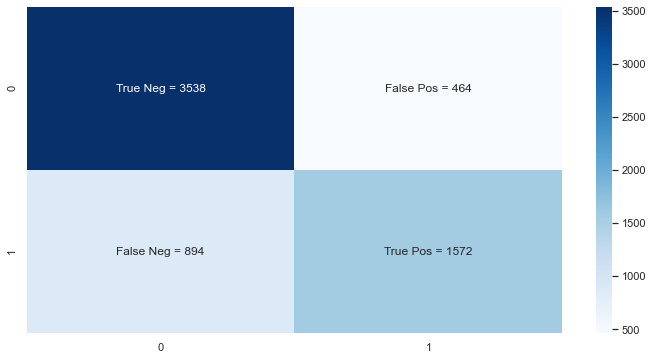

In [141]:
# Plotting confusion matrix of train data

plt.figure(figsize=[12,6])
labels = ['True Neg = 3538','False Pos = 464','False Neg = 894','True Pos = 1572']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.show()

#### Metrics beyond simply accuracy

In [142]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

In [143]:
# Calculating the sensitivity of our model

Sensitivity = TP / float(TP+FN)
Sensitivity

0.6374695863746959

In [144]:
# Calculating the specificity of our model

Specificity = TN / float(TN+FP)
Specificity

0.8840579710144928

In [145]:
# Calculating precision

Precision = TP / float(TP+FP)
Precision

0.7721021611001965

In [146]:
# Calculate false postive rate - predicting conversion when customer does not convert 

FPR = print(FP/ float(TN+FP))
FPR

0.11594202898550725


In [147]:
# Calculating positive predictive value 

PPV = print (TP / float(TP+FP))
PPV

0.7721021611001965


In [148]:
# Calculating Negative predictive value

NPV = print (TN / float(TN+ FN))
NPV

0.7982851985559567


In [149]:
# Calculating F1 Score

F1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)
F1

0.6983562860950688

### Plotting the ROC Curve

#### An ROC curve demonstrates several things:
#### It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
#### The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
#### The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [150]:
def roc_curve( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [151]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_prob.Converted, y_train_pred_prob.Conversion_Probability, drop_intermediate = False )

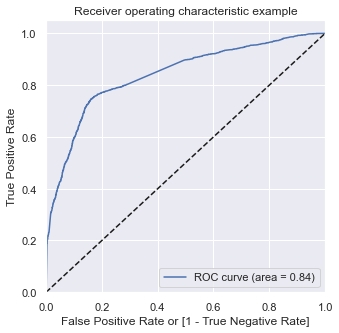

In [152]:
roc_curve(y_train_pred_prob.Converted, y_train_pred_prob.Conversion_Probability)

### Finding Optimal Cutoff Point

Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [153]:
# Let's create columns with different probability cutoffs 

numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_prob[i]= y_train_pred_prob.Conversion_Probability.map(lambda x: 1 if x > i else 0)
y_train_pred_prob.head()

Converted  Conversion_Probability  CustID  predicted  0.0  0.1  0.2  0.3  \
0          0                0.208725    1871          0    1    1    1    0   
1          0                0.217513    6795          0    1    1    1    0   
2          0                0.246004    3516          0    1    1    1    0   
3          0                0.634767    8105          1    1    1    1    1   
4          0                0.208725    3934          0    1    1    1    0   

   0.4  0.5  0.6  0.7  0.8  0.9  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    1    1    1    0    0    0  
4    0    0    0    0    0    0

In [154]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.381262  1.000000  0.000000
0.1   0.1  0.442795  0.990268  0.105447
0.2   0.2  0.643321  0.899432  0.485507
0.3   0.3  0.796691  0.759530  0.819590
0.4   0.4  0.803185  0.714517  0.857821
0.5   0.5  0.790043  0.637470  0.884058
0.6   0.6  0.773500  0.550284  0.911044
0.7   0.7  0.752783  0.439984  0.945527
0.8   0.8  0.734230  0.345904  0.973513
0.9   0.9  0.694960  0.209246  0.994253


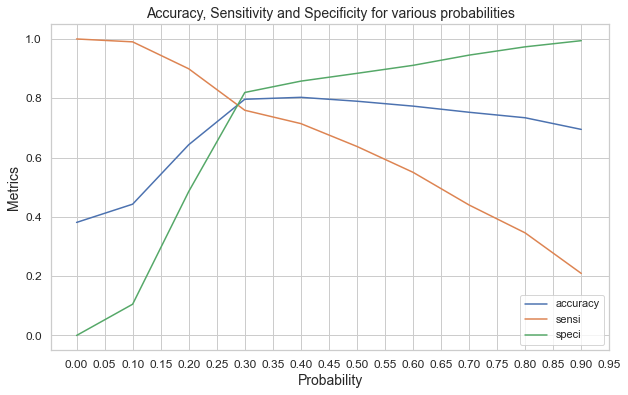

In [155]:
# Let's plot accuracy sensitivity and specificity for various probabilities.

sns.set_style("whitegrid")
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'], figsize=(10,6))
plt.xticks(np.arange(0, 1, step=0.05), size = 12)
plt.yticks(size = 12)
plt.title('Accuracy, Sensitivity and Specificity for various probabilities', fontsize=14)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.show()

#### From the curve above, 0.29 can be taken as the optimum point to take it as a cutoff probability

In [156]:
y_train_pred_prob['final_predicted'] = y_train_pred_prob.Conversion_Probability.map( lambda x: 1 if x > 0.29 else 0)

y_train_pred_prob.head()

Converted  Conversion_Probability  CustID  predicted  0.0  0.1  0.2  0.3  \
0          0                0.208725    1871          0    1    1    1    0   
1          0                0.217513    6795          0    1    1    1    0   
2          0                0.246004    3516          0    1    1    1    0   
3          0                0.634767    8105          1    1    1    1    1   
4          0                0.208725    3934          0    1    1    1    0   

   0.4  0.5  0.6  0.7  0.8  0.9  final_predicted  
0    0    0    0    0    0    0                0  
1    0    0    0    0    0    0                0  
2    0    0    0    0    0    0                0  
3    1    1    1    0    0    0                1  
4    0    0    0    0    0    0                0

#### Metrics for the Training dataset for cut-off 0.29

In [157]:
# Let's check the overall accuracy.

metrics.accuracy_score(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted)

0.7946815089672232

In [158]:
# Checking confusion matrix  

cm2 = confusion_matrix(y_train_pred_prob.Converted, y_train_pred_prob.final_predicted)
cm2

array([[3252,  750],
       [ 578, 1888]])

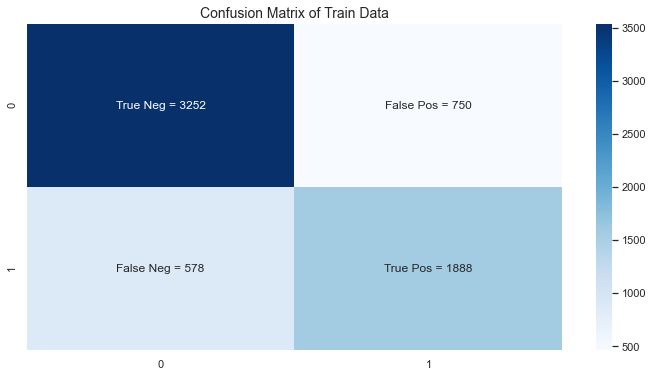

In [159]:
# Plotting confusion matrix of train data after threshold decision

plt.figure(figsize=[12,6])
labels = ['True Neg = 3252','False Pos = 750','False Neg = 578','True Pos = 1888']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix of Train Data', fontsize=14)
plt.show()

In [160]:
TP = cm2[1,1] # true positive 
TN = cm2[0,0] # true negatives
FP = cm2[0,1] # false positives
FN = cm2[1,0] # false negatives

In [161]:
# Calculating the sensitivity of our model

Sensitivity = TP / float(TP+FN)
Sensitivity

0.7656123276561233

In [162]:
# Calculating the specificity of our model

Specificity = TN / float(TN+FP)
Specificity

0.8125937031484258

In [163]:
# Calculating precision

Precision = TP / float(TP+FP)
Precision

0.7156937073540561

In [164]:
# Calculate false postive rate - predicting conversion when customer does not convert 

FPR = print(FP/ float(TN+FP))
FPR

0.1874062968515742


In [165]:
# Calculating positive predictive value 

PPV = print (TP / float(TP+FP))
PPV

0.7156937073540561


In [166]:
# Calculating Negative predictive value

NPV = print (TN / float(TN+ FN))
NPV

0.8490861618798956


In [167]:
# Calculating F1 Score

F1 = 2*(Precision*Sensitivity)/(Precision+Sensitivity)
F1

0.7398119122257054

#### Assign a Lead Score to the Training dataset based on the Conversion probability of the final_Predictions

In [168]:
y_train_pred_prob['Lead_Score'] = y_train_pred_prob.Conversion_Probability.map( lambda x: round(x*100))

y_train_pred_prob[['Converted','Conversion_Probability','CustID','final_predicted','Lead_Score']].head()

Converted  Conversion_Probability  CustID  final_predicted  Lead_Score
0          0                0.208725    1871                0          21
1          0                0.217513    6795                0          22
2          0                0.246004    3516                0          25
3          0                0.634767    8105                1          63
4          0                0.208725    3934                0          21

### Precision and recall tradeoff

In [169]:
p, r, thresholds = metrics.precision_recall_curve(y_train_pred_prob.Converted, y_train_pred_prob.Conversion_Probability)

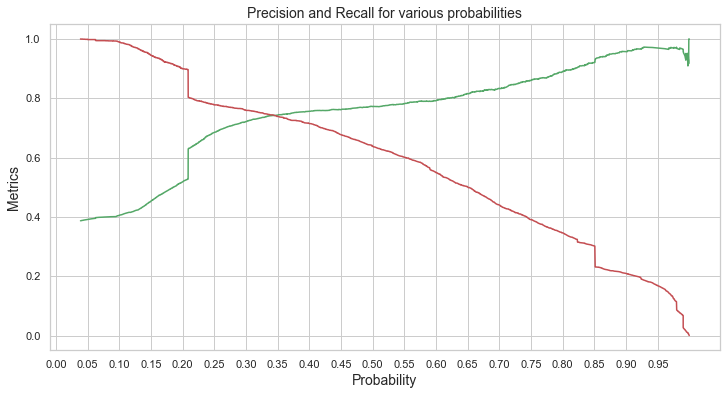

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.xticks(np.arange(0, 1, step=0.05))
plt.title('Precision and Recall for various probabilities', fontsize=14)
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Metrics', fontsize=14)
plt.show()


### Step 11: Making predictions on the test set

In [171]:
X_test.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
4269             0            0          8.0                         1011   
2376             0            0          0.0                            0   
7766             0            0          5.0                           59   
9199             0            0          0.0                            0   
4359             0            0          0.0                            0   

      Page Views Per Visit  A free copy of Mastering The Interview  \
4269                   6.0                                       0   
2376                   0.0                                       0   
7766                   5.0                                       0   
9199                   0.0                                       0   
4359                   0.0                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
4269                                    0                          0   
2376                                    0                          1   
7766                                    0                          0   
9199                                    0                          0   
4359                                    0                          1   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
4269                        0                           0   
2376                        0                           0   
7766                        0                           0   
9199                        0                           0   
4359                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
4269                           1                     0                   0   
2376                           0                     0                   0   
7766                           0                     0                   1   
9199                           0                     0                   0   
4359                           0                     0                   0   

      Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
4269                      0                   0                       0   
2376                      0                   0                       0   
7766                      0                   0                       0   
9199                      0                   0                       1   
4359                      0                   0                       0   

      Lead Source_Organic Search  Lead Source_Pay per Click Ads  \
4269                           0                              0   
2376                           0                              0   
7766                           0                              0   
9199                           0                              0   
4359                           0                              0   

      Lead Source_Press_Release  Lead Source_Reference  \
4269                          0                      0   
2376                          0                      1   
7766                          0                      0   
9199                          0                      0   
4359                          0                      1   

      Lead Source_Referral Sites  Lead Source_Social Media  \
4269                           0                         0   
2376                           0                         0   
7766                           0                         0   
9199                           0                         0   
4359                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
4269                    0                             0                 0   
2376                    0                             0                 0   
7766                    0                     

In [172]:
X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']] = scaler.transform(X_test[['TotalVisits','Total Time Spent on Website','Page Views Per Visit']])

X_test.head()

Do Not Email  Do Not Call  TotalVisits  Total Time Spent on Website  \
4269             0            0     1.748187                     0.964504   
2376             0            0    -1.150743                    -0.885371   
7766             0            0     0.661088                    -0.777416   
9199             0            0    -1.150743                    -0.885371   
4359             0            0    -1.150743                    -0.885371   

      Page Views Per Visit  A free copy of Mastering The Interview  \
4269              2.115928                                       0   
2376             -1.269100                                       0   
7766              1.551757                                       0   
9199             -1.269100                                       0   
4359             -1.269100                                       0   

      Lead Origin_Landing Page Submission  Lead Origin_Lead Add Form  \
4269                                    0                          0   
2376                                    0                          1   
7766                                    0                          0   
9199                                    0                          0   
4359                                    0                          1   

      Lead Origin_Lead Import  Lead Origin_Quick Add Form  \
4269                        0                           0   
2376                        0                           0   
7766                        0                           0   
9199                        0                           0   
4359                        0                           0   

      Lead Source_Direct Traffic  Lead Source_Facebook  Lead Source_Google  \
4269                           1                     0                   0   
2376                           0                     0                   0   
7766                           0                     0                   1   
9199                           0                     0                   0   
4359                           0                     0                   0   

      Lead Source_Live Chat  Lead Source_NC_EDM  Lead Source_Olark Chat  \
4269                      0                   0                       0   
2376                      0                   0                       0   
7766                      0                   0                       0   
9199                      0                   0                       1   
4359                      0                   0                       0   

      Lead Source_Organic Search  Lead Source_Pay per Click Ads  \
4269                           0                              0   
2376                           0                              0   
7766                           0                              0   
9199                           0                              0   
4359                           0                              0   

      Lead Source_Press_Release  Lead Source_Reference  \
4269                          0                      0   
2376                          0                      1   
7766                          0                      0   
9199                          0                      0   
4359                          0                      1   

      Lead Source_Referral Sites  Lead Source_Social Media  \
4269                           0                         0   
2376                           0                         0   
7766                           0                         0   
9199                           0                         0   
4359                           0                         0   

      Lead Source_WeLearn  Lead Source_Welingak Website  Lead Source_bing  \
4269                    0                             0                 0   
2376                    0                             0                 0   
7766                    0                     

In [173]:
# Dropping highly correlated dummy variables. Same as that was dropped in train set after analysis.
X_test = X_test.drop(['Lead Source_Facebook','Lead Source_Reference','Page Views Per Visit'], 1)

In [174]:
X_test.shape

(2772, 53)

In [175]:
col

['Do Not Email',
 'Total Time Spent on Website',
 'Lead Origin_Lead Add Form',
 'Lead Source_Direct Traffic',
 'Lead Source_Google',
 'Lead Source_Organic Search',
 'Lead Source_Referral Sites',
 'Lead Source_Welingak Website',
 'Specialization_IT Projects Management',
 'Specialization_Rural and Agribusiness',
 'What is your current occupation_Working Professional']

In [176]:
len(col)

11

In [177]:
# Making Predictions on the X_test dataset

X_test = X_test[col].copy()
X_test_sm = sm.add_constant(X_test)
y_test_pred = logm_sm.predict(X_test_sm)

In [178]:
# Reshaping to an array

y_test_pred = y_test_pred.values.reshape(-1)
y_test_pred[:10]

array([0.4429221 , 0.85068526, 0.74522208, 0.20872483, 0.85068526,
       0.33476611, 0.52934598, 0.20155307, 0.22719923, 0.16893202])

In [179]:
# Creating a dataframe with the given conversion rate and the predicted probabilities

y_test_pred_prob = pd.DataFrame({'Converted':y_test.values, 'Conversion_Probability':y_test_pred})
y_test_pred_prob['CustID'] = y_test.index
y_test_pred_prob.head(10)

Converted  Conversion_Probability  CustID
0          1                0.442922    4269
1          1                0.850685    2376
2          1                0.745222    7766
3          0                0.208725    9199
4          1                0.850685    4359
5          1                0.334766    9186
6          1                0.529346    1631
7          1                0.201553    8963
8          0                0.227199    8007
9          1                0.168932    5324

In [180]:
# Creating new column 'predicted' with 1 if Conversion_Probability > 0.29 else 0,
# as was found earlier during evaluation on training set

y_test_pred_prob['predicted'] = y_test_pred_prob.Conversion_Probability.map(lambda x: 1 if x > 0.29 else 0)
y_test_pred_prob.head()

Converted  Conversion_Probability  CustID  predicted
0          1                0.442922    4269          1
1          1                0.850685    2376          1
2          1                0.745222    7766          1
3          0                0.208725    9199          0
4          1                0.850685    4359          1

In [181]:
# Checking confusion matrix on test data  

cm_test = metrics.confusion_matrix(y_test_pred_prob.Converted, y_test_pred_prob.predicted)

In [182]:
cm_test

array([[1353,  324],
       [ 268,  827]])

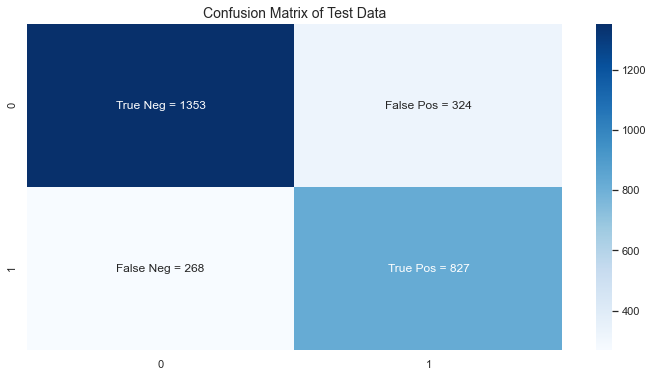

In [183]:
# Plotting confusion matrix of test data

plt.figure(figsize=[12,6])
labels = ['True Neg = 1353','False Pos = 324','False Neg = 268','True Pos = 827']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm_test, annot=labels, fmt='', cmap='Blues')
plt.title('Confusion Matrix of Test Data', fontsize=14)
plt.show()

In [184]:
# Let's check the overall accuracy.

metrics.accuracy_score(y_test_pred_prob.Converted, y_test_pred_prob.predicted)

0.7864357864357865

In [185]:
TP = cm_test[1,1] # true positive 
TN = cm_test[0,0] # true negatives
FP = cm_test[0,1] # false positives
FN = cm_test[1,0] # false negatives

In [186]:
# Calculating the sensitivity of our model

Sensitivity_test_data = TP / float(TP+FN)
Sensitivity_test_data

0.7552511415525114

In [187]:
# Calculating the specificity of our model

Specificity_test_data = TN / float(TN+FP)
Specificity_test_data

0.8067978533094812

In [188]:
# Calculating precision

Precision_test_data = TP / float(TP+FP)
Precision_test_data

0.7185056472632494

In [189]:
# Calculate false postive rate - predicting conversion when customer does not convert 

FPR_test_data = print(FP/ float(TN+FP))
FPR_test_data

0.19320214669051877


In [190]:
# Calculating positive predictive value 

PPV_test_data = print (TP / float(TP+FP))
PPV_test_data

0.7185056472632494


In [191]:
# Calculating Negative predictive value

NPV_test_data = print (TN / float(TN+ FN))
NPV_test_data

0.8346699568167798


In [192]:
# Calculating F1 Score

F1_test_data = 2*(Precision*Sensitivity_test_data)/(Precision+Sensitivity_test_data)
F1_test_data

0.7349405246334066

In [193]:
# Assign a Lead Score to the Test dataset based on the Conversion probability of the final_Predictions

y_test_pred_prob['Lead_Score'] = y_test_pred_prob.Conversion_Probability.map( lambda x: round(x*100))

y_test_pred_prob[['Converted','Conversion_Probability','CustID','predicted','Lead_Score']].head()

Converted  Conversion_Probability  CustID  predicted  Lead_Score
0          1                0.442922    4269          1          44
1          1                0.850685    2376          1          85
2          1                0.745222    7766          1          75
3          0                0.208725    9199          0          21
4          1                0.850685    4359          1          85

### Step 12: Determining Feature Importance

In [194]:
model_parameters = logm_sm.params[1:]
model_parameters

Do Not Email                                           -1.375672
Total Time Spent on Website                             1.096080
Lead Origin_Lead Add Form                               3.072615
Lead Source_Direct Traffic                             -0.924293
Lead Source_Google                                     -0.581474
Lead Source_Organic Search                             -0.676997
Lead Source_Referral Sites                             -1.188444
Lead Source_Welingak Website                            2.128385
Specialization_IT Projects Management                   0.392915
Specialization_Rural and Agribusiness                   0.756211
What is your current occupation_Working Professional    2.869066
dtype: float64

In [195]:
# Ranking feature variables based on their relative coefficient values

sorted_index = np.argsort(model_parameters,kind='quicksort')
sorted_index

Do Not Email                                             0
Total Time Spent on Website                              6
Lead Origin_Lead Add Form                                3
Lead Source_Direct Traffic                               5
Lead Source_Google                                       4
Lead Source_Organic Search                               8
Lead Source_Referral Sites                               9
Lead Source_Welingak Website                             1
Specialization_IT Projects Management                    7
Specialization_Rural and Agribusiness                   10
What is your current occupation_Working Professional     2
dtype: int64

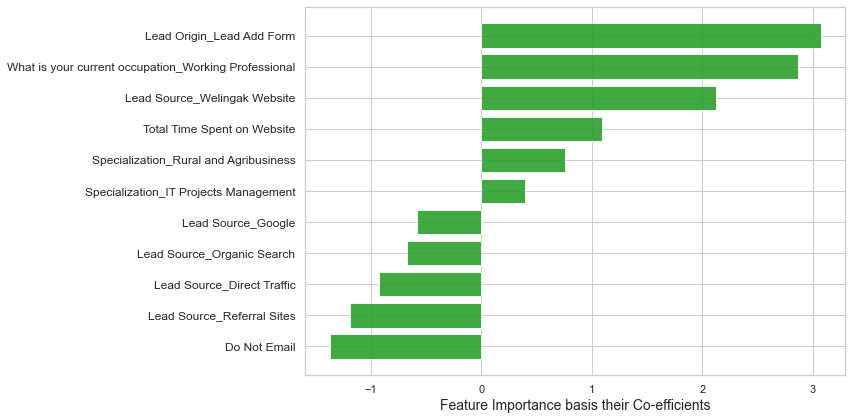

In [196]:
# Plotting the Feature Importance of each feature in the model for better visualization.
pos = np.arange(sorted_index.shape[0])

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, model_parameters[sorted_index], align='center', color = 'tab:green',alpha=0.9)
ax.set_yticks(pos)
ax.set_yticklabels(np.array(X_train[col].columns)[sorted_index], fontsize=12)
ax.set_xlabel('Feature Importance basis their Co-efficients', fontsize=14)

plt.tight_layout()   
plt.show()

### Step 12: Final Observations and Recommendations

#### The Final Evaluation Metrics for the train Dataset: 

* The Accuracy is    : 0.79
* The Sensitivity is : 0.77
* The Specificity is : 0.81
* The Precision is   : 0.71
* The f1 score is    : 0.73
    
#### The Final Evaluation Metrics for the test Dataset: 

* The Accuracy is    : 0.78
* The Sensitivity is : 0.76
* The Specificity is : 0.80
* The Precision is   : 0.71
* The f1 score is    : 0.73
    
#### X-Education has a better chance of converting a potential lead when:
* **When the Lead origin was Lead Add form**
Leads who have responded/ or engaged through Lead Add Forms have had a higher chances of getting converted
* **Current Occupation is specified as Working Professional:**
Leads who are working professionals have high chances of getting converted.
* **The Lead Source who are coming from Welingak Website:**
Leads who are coming from Welingak Website have converted
* **The total time spent on the Website is high:**
Leads who have spent more time on the website have converted
* **Specialization is either Rural and Agri Business or IT Projects Management**
Leads who have Specialization in either Rural and Agri Business or IT Projects Management have higher chances of getting converted. 